# Pattern Compare

Aims to answer the question **Are there any key similarities or differences between malicious and benign samples in terms of API Call Patterns?** in **4.2.6. Dataset Analysis** of the study.

Note that this notebook only makes use of the verified xxxx_SampleHash_Common.csv file which represents a significant majority of the entire Oliveira dataset.  

## Import Libraries/Datasets

In [1]:
import pandas as pd
# from difflib import SequenceMatcher
import Levenshtein
import matplotlib.pyplot as plt
import time

malicious_df = pd.read_csv('./Manual_DBSCAN_Encoded_Clustering.csv', low_memory=False) #This should point to a verified <DataClustering>_SampleHash_Common.csv file
benign_df = pd.read_csv('./API_Patterns_Benign.csv') #This should point to the API_Patterns.csv file

#DROP ROWS WITH NA
import numpy as nan
malicious_df.dropna(inplace=True, subset=['type'])
malicious_df['type'].unique()

#Load list of API calls
API_LIST = "../api_calls.txt"
DELIMITER = "NaN"
API_FILE = open(API_LIST,"r")
APIS = API_FILE.readline().split
# APIS.append(DELIMITER) #serves as a label for NaN values for Instance-based datasets
API_FILE.close()

C:\Users\ejose\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## DataFrame Preview

In [2]:
malicious_df.replace(to_replace='-',value='_', inplace=True)
malicious_df

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_94,t_95,t_96,t_97,t_98,t_99,malware,type,pattern,cluster
0,071e8c3f8922e186e57548cd4c703a5d,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW,1,trojan,"RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClos...",0
1,33f8e6d08a6aae939f25a8e0d63dd523,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,...,GetSystemWindowsDirectoryW,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,1,pua,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor...",1
2,b68abd064e975e1c6d5f25e748663076,SetUnhandledExceptionFilter,OleInitialize,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,RegCloseKey,RegOpenKeyExA,RegQueryValueExA,RegCloseKey,RegEnumKeyExA,RegOpenKeyExA,1,trojan,"SetUnhandledExceptionFilter,OleInitialize,LdrL...",2
3,72049be7bd30ea61297ea624ae198067,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,...,NtWriteVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,NtWriteVirtualMemory,NtProtectVirtualMemory,NtWriteVirtualMemory,1,trojan,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor...",3
4,c9b3700a77facf29172f32df6bc77f48,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegEnumKeyExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40154,e3d6d58faa040f0f9742c9d0eaf58be4,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",17
40155,9b917bab7f32188ae40c744f2be9aaf8,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtDelayExecution,EnumWindows,GetSystemTimeAsFileTime,NtDelayExecution,EnumWindows,GetSystemTimeAsFileTime,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",11490
40156,35a18ee05f75f04912018d9f462cb990,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",11491
40157,654139d715abcf7ecdddbef5a84f224b,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",17


In [3]:
#Drop row that is falsely labelled.
malicious_df.drop(malicious_df[(malicious_df['type']=='_')].index, inplace=True)
malicious_df

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_94,t_95,t_96,t_97,t_98,t_99,malware,type,pattern,cluster
0,071e8c3f8922e186e57548cd4c703a5d,RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtQueryAttributesFile,LoadStringA,...,NtMapViewOfSection,NtClose,GetSystemMetrics,NtAllocateVirtualMemory,CreateActCtxW,GetSystemWindowsDirectoryW,1,trojan,"RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClos...",0
1,33f8e6d08a6aae939f25a8e0d63dd523,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,...,GetSystemWindowsDirectoryW,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,GetSystemMetrics,1,pua,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor...",1
2,b68abd064e975e1c6d5f25e748663076,SetUnhandledExceptionFilter,OleInitialize,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,RegCloseKey,RegOpenKeyExA,RegQueryValueExA,RegCloseKey,RegEnumKeyExA,RegOpenKeyExA,1,trojan,"SetUnhandledExceptionFilter,OleInitialize,LdrL...",2
3,72049be7bd30ea61297ea624ae198067,GetSystemTimeAsFileTime,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,...,NtWriteVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,NtWriteVirtualMemory,NtProtectVirtualMemory,NtWriteVirtualMemory,1,trojan,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor...",3
4,c9b3700a77facf29172f32df6bc77f48,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegEnumKeyExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40154,e3d6d58faa040f0f9742c9d0eaf58be4,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",17
40155,9b917bab7f32188ae40c744f2be9aaf8,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtDelayExecution,EnumWindows,GetSystemTimeAsFileTime,NtDelayExecution,EnumWindows,GetSystemTimeAsFileTime,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",11490
40156,35a18ee05f75f04912018d9f462cb990,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",11491
40157,654139d715abcf7ecdddbef5a84f224b,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,1,trojan,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce...",17


In [4]:
benign_df

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,pattern
0,5b51d65972a349f90a86984c26b12b30,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,NtQueryDirectoryFile,NtClose,LdrGetProcedureAddress,CoCreateInstance,NtOpenSection,CreateDirectoryW,NtCreateFile,LdrGetProcedureAddress,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
1,ceb8cc125478fad641daa4e04e9b2f19,GetSystemInfo,NtAllocateVirtualMemory,NtOpenSection,GetTempPathW,CreateDirectoryW,GetFileAttributesW,FindFirstFileExW,DeleteFileW,NtQueryDirectoryFile,...,NtClose,NtCreateMutant,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,NtClose,NtCreateMutant,NtClose,NtCreateFile,"GetSystemInfo,NtAllocateVirtualMemory,NtOpenSe..."
2,f108600edf46d7c20f6acc522aeba6df,GetSystemTimeAsFileTime,NtProtectVirtualMemory,SetUnhandledExceptionFilter,GetTimeZoneInformation,GetSystemTimeAsFileTime,GetTimeZoneInformation,GetSystemTimeAsFileTime,GetTimeZoneInformation,GetSystemTimeAsFileTime,...,SetErrorMode,GetFileAttributesExW,SetErrorMode,NtAllocateVirtualMemory,SetErrorMode,GetFileAttributesExW,SetErrorMode,FindFirstFileExW,NtQueryDirectoryFile,"GetSystemTimeAsFileTime,NtProtectVirtualMemory..."
3,711be6337cb78a948f04759a0bd210ce,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,LdrGetProcedureAddress,NtAllocateVirtualMemory,LdrGetProcedureAddress,GetSystemMetrics,LdrLoadDll,LdrGetProcedureAddress,GetSystemMetrics,NtAllocateVirtualMemory,LdrLoadDll,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
4,6de26f67ceb1e3303b889489010f4c3f,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,NtQueryDirectoryFile,NtClose,LdrGetProcedureAddress,GetSystemWindowsDirectoryW,LoadStringW,GetSystemWindowsDirectoryW,GetSystemDirectoryW,RegOpenKeyExW,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,d282ef96a93986f89825508812958354,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,NtClose,LdrGetProcedureAddress,NtAllocateVirtualMemory,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle,LdrGetProcedureAddress,"SetErrorMode,OleInitialize,LdrGetDllHandle,Ldr..."
1075,c0389d256f976044adf570f0df908953,GetSystemTimeAsFileTime,SetUnhandledExceptionFilter,GetCursorPos,SetErrorMode,FindResourceW,SetWindowsHookExW,CoInitializeEx,NtDuplicateObject,NtAllocateVirtualMemory,...,NtAllocateVirtualMemory,LdrLoadDll,LdrGetProcedureAddress,NtAllocateVirtualMemory,GetSystemMetrics,RegOpenKeyExW,NtAllocateVirtualMemory,GetSystemMetrics,NtAllocateVirtualMemory,"GetSystemTimeAsFileTime,SetUnhandledExceptionF..."
1076,20316e717de5db169aecbb67377504ce,SetUnhandledExceptionFilter,NtCreateMutant,NtAllocateVirtualMemory,NtClose,NtCreateMutant,NtClose,NtCreateMutant,NtClose,NtAllocateVirtualMemory,...,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,"SetUnhandledExceptionFilter,NtCreateMutant,NtA..."
1077,ce945d424b93ea73fbbedf0254f6bc07,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,FindResourceExW,LoadResource,"NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOp..."


## Identify Malware Types

Same as the output of `1 MalwareTypes_in_Dataset.txt`

In [5]:
'''Identify popular malware types in the dataset per Type as validated by VirusTotal.'''

def identify(malware_type:str):
    '''Identify and count the malware types per type'''
    print(f"{malware_type.upper()} LABEL")
    unique = list(malicious_df[malware_type].unique())
    if '_' in unique:
        unique.remove('_')
    quantities = []
    for t in unique:
        quantities.append([t, len(malicious_df[malicious_df[malware_type]==t])])
    quantities.sort(key=lambda ls: ls[1], reverse=True)
    for q in quantities:
        print(f"{q[0]:12s}: {q[1]}")
    print("")
    
'''Executes the identification for each type'''
types = ['type']
for i in types:    
    identify(i)

TYPE LABEL
trojan      : 33352
downloader  : 2249
pua         : 2135
adware      : 1815
ransomware  : 341
miner       : 125
virus       : 79
spyware     : 48
hacktool    : 7
dropper     : 5
worm        : 3



## Extract API Patterns

In [6]:
malicious_patterns = malicious_df['pattern'].to_list()
print("Malicious Sample API Patterns: ", len(malicious_patterns))
#display(malicious_patterns)

benign_patterns = benign_df['pattern'].to_list()
print("Benign Sample API Patterns: ", len(benign_patterns))
#display(benign_patterns)

Malicious Sample API Patterns:  40159
Benign Sample API Patterns:  1079


## Compare API Call Patterns

**Note that this uses the full API Call Patterns (i.e., Time-based Behaviors)**

Find those most similar unique malicious API call patterns that match those unique benign API call patterns.

In [7]:
#This code block may take a while to complete. SequenceMatcher.ratio() is deemed slow even by its documentation.
print("Comparing API Call Patterns...")
ratio = 0
ratios = []
start = time.time()

unique_malicious = list(malicious_df['pattern'].unique())
unique_benign = list(benign_df['pattern'].unique())
print(f"No. of unique malicious patterns: {len(unique_malicious)}")
print(f"No. of unique benign patterns: {len(unique_benign)}")
print("")
for m,ma in enumerate(unique_malicious): #For efficiency's sake, let's just compare it to unique malicious samples. Hashes that match the same malicious pattern will be collected in batches instead of one by one.
    mal_df = malicious_df[malicious_df['pattern']== ma]
    st = time.time()
    #if ma in unique_benign: # Only compute those that unique malicious patterns that are also in unique benign (shortens overall computation time)
    for b, be in enumerate(unique_benign): #For efficiency's sake, let's just compare it to unique benign samples. Hashes that match the same benign pattern will be collected in batches instead of one by one.
        ratios.append({'ratio': Levenshtein.seqratio(ma.split(',') , be.split(',')), #<=== SequenceMatcher.ratio() is too slow given the number of patterns to compare.
                    'benign_pattern':be, 'malicious_pattern': ma,
                    'type':mal_df['type'].to_list(), 
                    'malicious_hash':mal_df['hash'].to_list(), 
                    'benign_hash':benign_df[benign_df['pattern'] == be]['hash'].to_list()})
    print(f"Unique Mal. Pattern {m} {ma[0:30]}... @ {time.time()-st:.4f}s")
elapsed = time.time()-start

Comparing API Call Patterns...
No. of unique malicious patterns: 11492
No. of unique benign patterns: 624

Unique Mal. Pattern 0 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.7460s
Unique Mal. Pattern 1 GetSystemTimeAsFileTime,NtAllo... @ 0.6384s
Unique Mal. Pattern 2 SetUnhandledExceptionFilter,Ol... @ 0.6043s
Unique Mal. Pattern 3 GetSystemTimeAsFileTime,NtAllo... @ 0.5837s
Unique Mal. Pattern 4 GetSystemTimeAsFileTime,LdrLoa... @ 0.6254s
Unique Mal. Pattern 5 LdrGetProcedureAddress,NtAlloc... @ 0.6117s
Unique Mal. Pattern 6 NtClose,NtOpenKey,NtQueryValue... @ 0.5998s
Unique Mal. Pattern 7 GetSystemTimeAsFileTime,LdrLoa... @ 0.5692s
Unique Mal. Pattern 8 GetSystemTimeAsFileTime,LdrLoa... @ 0.5744s
Unique Mal. Pattern 9 GetSystemTimeAsFileTime,NtAllo... @ 0.5977s
Unique Mal. Pattern 10 LdrGetDllHandle,LdrGetProcedur... @ 0.6163s
Unique Mal. Pattern 11 GetSystemTimeAsFileTime,LdrLoa... @ 0.6076s
Unique Mal. Pattern 12 GetSystemTimeAsFileTime,LdrGet... @ 0.5596s
Unique Mal. Pattern 13 GetSystem

Unique Mal. Pattern 121 LdrLoadDll,LdrGetProcedureAddr... @ 0.6403s
Unique Mal. Pattern 122 GetSystemTimeAsFileTime,LdrLoa... @ 0.7122s
Unique Mal. Pattern 123 GetSystemTimeAsFileTime,LdrLoa... @ 0.6663s
Unique Mal. Pattern 124 GetSystemTimeAsFileTime,LdrLoa... @ 0.6293s
Unique Mal. Pattern 125 GetSystemTimeAsFileTime,LdrLoa... @ 0.7470s
Unique Mal. Pattern 126 GetSystemTimeAsFileTime,LdrLoa... @ 0.6721s
Unique Mal. Pattern 127 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6543s
Unique Mal. Pattern 128 NtAllocateVirtualMemory,SetErr... @ 0.6373s
Unique Mal. Pattern 129 GetSystemTimeAsFileTime,LdrLoa... @ 0.7547s
Unique Mal. Pattern 130 NtCreateFile,NtQueryInformatio... @ 0.7162s
Unique Mal. Pattern 131 GetSystemTimeAsFileTime,NtAllo... @ 0.6781s
Unique Mal. Pattern 132 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6997s
Unique Mal. Pattern 133 GetSystemTimeAsFileTime,LdrLoa... @ 0.6102s
Unique Mal. Pattern 134 LdrLoadDll,LdrGetProcedureAddr... @ 0.6080s
Unique Mal. Pattern 135 NtDeviceIoControlFile,Nt

Unique Mal. Pattern 242 GetSystemTimeAsFileTime,LdrLoa... @ 0.6320s
Unique Mal. Pattern 243 LdrLoadDll,LdrGetProcedureAddr... @ 0.5589s
Unique Mal. Pattern 244 GetSystemTimeAsFileTime,LdrLoa... @ 0.6621s
Unique Mal. Pattern 245 __exception__,NtAllocateVirtua... @ 0.7298s
Unique Mal. Pattern 246 SetUnhandledExceptionFilter,Nt... @ 0.6618s
Unique Mal. Pattern 247 GetSystemTimeAsFileTime,LdrLoa... @ 0.6712s
Unique Mal. Pattern 248 SetErrorMode,OleInitialize,Ldr... @ 0.7234s
Unique Mal. Pattern 249 GetSystemTimeAsFileTime,LdrLoa... @ 0.6758s
Unique Mal. Pattern 250 GetSystemTimeAsFileTime,LdrLoa... @ 0.6227s
Unique Mal. Pattern 251 NtAllocateVirtualMemory,SetErr... @ 0.7002s
Unique Mal. Pattern 252 GetSystemTimeAsFileTime,LdrLoa... @ 0.6561s
Unique Mal. Pattern 253 GetSystemTimeAsFileTime,LdrLoa... @ 0.6322s
Unique Mal. Pattern 254 SetErrorMode,OleInitialize,Ldr... @ 0.7710s
Unique Mal. Pattern 255 LdrLoadDll,LdrGetProcedureAddr... @ 0.6292s
Unique Mal. Pattern 256 GetSystemTimeAsFileTime,

Unique Mal. Pattern 363 GetSystemTimeAsFileTime,LdrLoa... @ 0.5645s
Unique Mal. Pattern 364 GetSystemTimeAsFileTime,LdrLoa... @ 0.6177s
Unique Mal. Pattern 365 GetSystemTimeAsFileTime,NtAllo... @ 0.6455s
Unique Mal. Pattern 366 LdrLoadDll,LdrGetProcedureAddr... @ 0.6452s
Unique Mal. Pattern 367 GetSystemTimeAsFileTime,LdrLoa... @ 0.6846s
Unique Mal. Pattern 368 GetSystemTimeAsFileTime,LdrLoa... @ 0.5992s
Unique Mal. Pattern 369 GetSystemTimeAsFileTime,LdrLoa... @ 0.5895s
Unique Mal. Pattern 370 GetSystemTimeAsFileTime,LdrLoa... @ 0.6069s
Unique Mal. Pattern 371 GetSystemTimeAsFileTime,LdrLoa... @ 0.5772s
Unique Mal. Pattern 372 GetSystemTimeAsFileTime,LdrGet... @ 0.6033s
Unique Mal. Pattern 373 GetSystemTimeAsFileTime,LdrLoa... @ 0.5943s
Unique Mal. Pattern 374 GetSystemTimeAsFileTime,LdrLoa... @ 0.5673s
Unique Mal. Pattern 375 LdrLoadDll,LdrGetProcedureAddr... @ 0.5824s
Unique Mal. Pattern 376 GetSystemTimeAsFileTime,LdrLoa... @ 0.5632s
Unique Mal. Pattern 377 GetSystemTimeAsFileTime,

Unique Mal. Pattern 484 GetSystemTimeAsFileTime,GetSys... @ 0.6516s
Unique Mal. Pattern 485 GetSystemTimeAsFileTime,NtAllo... @ 0.6254s
Unique Mal. Pattern 486 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.7425s
Unique Mal. Pattern 487 GetSystemTimeAsFileTime,LdrLoa... @ 0.6971s
Unique Mal. Pattern 488 GetSystemTimeAsFileTime,LdrGet... @ 0.6482s
Unique Mal. Pattern 489 GetSystemTimeAsFileTime,LdrLoa... @ 0.7175s
Unique Mal. Pattern 490 NtAllocateVirtualMemory,SetErr... @ 0.6172s
Unique Mal. Pattern 491 NtAllocateVirtualMemory,SetErr... @ 0.6593s
Unique Mal. Pattern 492 GetSystemTimeAsFileTime,NtAllo... @ 0.8020s
Unique Mal. Pattern 493 GetSystemTimeAsFileTime,LdrLoa... @ 0.6823s
Unique Mal. Pattern 494 GetSystemTimeAsFileTime,NtAllo... @ 0.6575s
Unique Mal. Pattern 495 LdrLoadDll,SetErrorMode,LdrLoa... @ 0.6518s
Unique Mal. Pattern 496 GetSystemTimeAsFileTime,LdrLoa... @ 0.5737s
Unique Mal. Pattern 497 LdrLoadDll,LdrGetProcedureAddr... @ 0.5854s
Unique Mal. Pattern 498 LdrLoadDll,LdrGetProcedu

Unique Mal. Pattern 605 GetSystemTimeAsFileTime,LdrGet... @ 0.5734s
Unique Mal. Pattern 606 GetSystemTimeAsFileTime,NtAllo... @ 0.6304s
Unique Mal. Pattern 607 GetSystemTimeAsFileTime,LdrLoa... @ 0.6336s
Unique Mal. Pattern 608 GetSystemTimeAsFileTime,LdrLoa... @ 0.6850s
Unique Mal. Pattern 609 NtAllocateVirtualMemory,SetErr... @ 0.6151s
Unique Mal. Pattern 610 NtAllocateVirtualMemory,SetErr... @ 0.7788s
Unique Mal. Pattern 611 GetSystemTimeAsFileTime,LdrLoa... @ 0.6566s
Unique Mal. Pattern 612 LdrGetDllHandle,LdrGetProcedur... @ 0.6270s
Unique Mal. Pattern 613 GetSystemTimeAsFileTime,LdrGet... @ 0.6159s
Unique Mal. Pattern 614 GetSystemTimeAsFileTime,NtAllo... @ 0.6371s
Unique Mal. Pattern 615 LdrGetDllHandle,IsDebuggerPres... @ 0.5785s
Unique Mal. Pattern 616 LdrGetDllHandle,LdrGetProcedur... @ 0.6248s
Unique Mal. Pattern 617 GetSystemTimeAsFileTime,LdrLoa... @ 0.7014s
Unique Mal. Pattern 618 GetSystemTimeAsFileTime,LdrLoa... @ 0.6804s
Unique Mal. Pattern 619 GetSystemTimeAsFileTime,

Unique Mal. Pattern 726 SetErrorMode,OleInitialize,Ldr... @ 0.6566s
Unique Mal. Pattern 727 GetSystemTimeAsFileTime,LdrLoa... @ 0.7006s
Unique Mal. Pattern 728 GetSystemTimeAsFileTime,LdrLoa... @ 0.6213s
Unique Mal. Pattern 729 GetSystemTimeAsFileTime,NtAllo... @ 1.4298s
Unique Mal. Pattern 730 NtAllocateVirtualMemory,SetErr... @ 0.6796s
Unique Mal. Pattern 731 LdrLoadDll,LdrGetProcedureAddr... @ 0.7042s
Unique Mal. Pattern 732 GetSystemTimeAsFileTime,LdrGet... @ 0.6200s
Unique Mal. Pattern 733 LdrLoadDll,LdrGetProcedureAddr... @ 0.6272s
Unique Mal. Pattern 734 GetSystemTimeAsFileTime,LdrLoa... @ 0.6593s
Unique Mal. Pattern 735 GetSystemTimeAsFileTime,LdrGet... @ 0.7274s
Unique Mal. Pattern 736 GetSystemTimeAsFileTime,LdrLoa... @ 0.7150s
Unique Mal. Pattern 737 LdrLoadDll,LdrGetProcedureAddr... @ 0.5912s
Unique Mal. Pattern 738 NtClose,NtOpenKey,NtQueryValue... @ 0.6735s
Unique Mal. Pattern 739 GetSystemTimeAsFileTime,LdrLoa... @ 0.6584s
Unique Mal. Pattern 740 GetSystemTimeAsFileTime,

Unique Mal. Pattern 847 GetSystemTimeAsFileTime,LdrLoa... @ 0.6668s
Unique Mal. Pattern 848 GetSystemTimeAsFileTime,LdrLoa... @ 0.6600s
Unique Mal. Pattern 849 GetSystemTimeAsFileTime,LdrGet... @ 0.7176s
Unique Mal. Pattern 850 NtDeviceIoControlFile,NtClose,... @ 0.6695s
Unique Mal. Pattern 851 __exception__,NtAllocateVirtua... @ 0.6381s
Unique Mal. Pattern 852 GetSystemTimeAsFileTime,LdrLoa... @ 0.6097s
Unique Mal. Pattern 853 NtAllocateVirtualMemory,NtFree... @ 0.6563s
Unique Mal. Pattern 854 LdrLoadDll,LdrGetProcedureAddr... @ 0.6304s
Unique Mal. Pattern 855 NtAllocateVirtualMemory,LdrLoa... @ 0.5862s
Unique Mal. Pattern 856 LdrLoadDll,LdrGetProcedureAddr... @ 0.7808s
Unique Mal. Pattern 857 GetSystemTimeAsFileTime,LdrLoa... @ 0.6517s
Unique Mal. Pattern 858 GetSystemTimeAsFileTime,LdrLoa... @ 0.6772s
Unique Mal. Pattern 859 GetSystemTimeAsFileTime,LdrLoa... @ 0.6347s
Unique Mal. Pattern 860 GetSystemTimeAsFileTime,LdrGet... @ 0.7454s
Unique Mal. Pattern 861 GetSystemTimeAsFileTime,

Unique Mal. Pattern 968 GetSystemTimeAsFileTime,LdrLoa... @ 0.6818s
Unique Mal. Pattern 969 GetSystemTimeAsFileTime,LdrLoa... @ 0.6388s
Unique Mal. Pattern 970 GetSystemTimeAsFileTime,LdrLoa... @ 0.7129s
Unique Mal. Pattern 971 GetSystemTimeAsFileTime,NtAllo... @ 0.6965s
Unique Mal. Pattern 972 GetSystemTimeAsFileTime,NtAllo... @ 0.6269s
Unique Mal. Pattern 973 GetSystemTimeAsFileTime,LdrLoa... @ 0.6528s
Unique Mal. Pattern 974 GetSystemTimeAsFileTime,LdrLoa... @ 0.6266s
Unique Mal. Pattern 975 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6382s
Unique Mal. Pattern 976 NtAllocateVirtualMemory,SetErr... @ 0.7057s
Unique Mal. Pattern 977 GetSystemTimeAsFileTime,LdrGet... @ 0.6448s
Unique Mal. Pattern 978 SetUnhandledExceptionFilter,Nt... @ 0.6017s
Unique Mal. Pattern 979 GetSystemTimeAsFileTime,LdrLoa... @ 0.7232s
Unique Mal. Pattern 980 GetSystemTimeAsFileTime,LdrLoa... @ 0.7039s
Unique Mal. Pattern 981 SetErrorMode,OleInitialize,Ldr... @ 0.7189s
Unique Mal. Pattern 982 GetSystemTimeAsFileTime,

Unique Mal. Pattern 1088 GetSystemTimeAsFileTime,NtAllo... @ 1.0401s
Unique Mal. Pattern 1089 SetErrorMode,OleInitialize,Ldr... @ 0.7037s
Unique Mal. Pattern 1090 GetSystemTimeAsFileTime,LdrLoa... @ 0.7440s
Unique Mal. Pattern 1091 GetSystemTimeAsFileTime,LdrGet... @ 0.5920s
Unique Mal. Pattern 1092 NtOpenFile,NtQueryInformationF... @ 0.6245s
Unique Mal. Pattern 1093 LdrGetProcedureAddress,LdrGetD... @ 0.6128s
Unique Mal. Pattern 1094 GetSystemTimeAsFileTime,LdrLoa... @ 0.6203s
Unique Mal. Pattern 1095 GetSystemTimeAsFileTime,LdrLoa... @ 0.6618s
Unique Mal. Pattern 1096 SetErrorMode,OleInitialize,Ldr... @ 0.6329s
Unique Mal. Pattern 1097 GetSystemTimeAsFileTime,LdrLoa... @ 0.7374s
Unique Mal. Pattern 1098 LdrLoadDll,LdrGetProcedureAddr... @ 0.6254s
Unique Mal. Pattern 1099 GetSystemTimeAsFileTime,LdrLoa... @ 0.6593s
Unique Mal. Pattern 1100 GetSystemTimeAsFileTime,LdrLoa... @ 0.8065s
Unique Mal. Pattern 1101 GetShortPathNameW,LdrGetDllHan... @ 0.6957s
Unique Mal. Pattern 1102 GetSystem

Unique Mal. Pattern 1207 GetSystemTimeAsFileTime,LdrLoa... @ 0.6536s
Unique Mal. Pattern 1208 GetSystemTimeAsFileTime,NtAllo... @ 0.6342s
Unique Mal. Pattern 1209 GetSystemTimeAsFileTime,LdrLoa... @ 0.6132s
Unique Mal. Pattern 1210 NtAllocateVirtualMemory,SetErr... @ 0.6288s
Unique Mal. Pattern 1211 GetSystemTimeAsFileTime,NtAllo... @ 0.6717s
Unique Mal. Pattern 1212 GetSystemTimeAsFileTime,LdrGet... @ 0.6323s
Unique Mal. Pattern 1213 GetSystemTimeAsFileTime,GetSys... @ 0.6724s
Unique Mal. Pattern 1214 GetSystemTimeAsFileTime,LdrGet... @ 0.6386s
Unique Mal. Pattern 1215 GetSystemTimeAsFileTime,LdrLoa... @ 0.7135s
Unique Mal. Pattern 1216 GetSystemTimeAsFileTime,LdrLoa... @ 0.6638s
Unique Mal. Pattern 1217 SetErrorMode,OleInitialize,Ldr... @ 0.7697s
Unique Mal. Pattern 1218 GetSystemTimeAsFileTime,NtAllo... @ 0.7963s
Unique Mal. Pattern 1219 GetSystemTimeAsFileTime,NtAllo... @ 0.7605s
Unique Mal. Pattern 1220 __exception__,LdrGetProcedureA... @ 0.6332s
Unique Mal. Pattern 1221 GetSystem

Unique Mal. Pattern 1326 GetSystemTimeAsFileTime,NtAllo... @ 0.6038s
Unique Mal. Pattern 1327 GetSystemTimeAsFileTime,NtAllo... @ 0.6475s
Unique Mal. Pattern 1328 NtAllocateVirtualMemory,SetErr... @ 0.7017s
Unique Mal. Pattern 1329 GetSystemTimeAsFileTime,LdrLoa... @ 0.6765s
Unique Mal. Pattern 1330 NtAllocateVirtualMemory,SetErr... @ 0.6111s
Unique Mal. Pattern 1331 NtAllocateVirtualMemory,SetErr... @ 0.6530s
Unique Mal. Pattern 1332 LdrLoadDll,LdrGetProcedureAddr... @ 0.6599s
Unique Mal. Pattern 1333 GetSystemTimeAsFileTime,NtAllo... @ 0.6732s
Unique Mal. Pattern 1334 GetSystemTimeAsFileTime,LdrLoa... @ 0.6882s
Unique Mal. Pattern 1335 GetSystemTimeAsFileTime,LdrLoa... @ 0.6577s
Unique Mal. Pattern 1336 LdrLoadDll,LdrGetProcedureAddr... @ 0.6336s
Unique Mal. Pattern 1337 GetSystemTimeAsFileTime,LdrGet... @ 0.6213s
Unique Mal. Pattern 1338 GetSystemTimeAsFileTime,LdrLoa... @ 0.7254s
Unique Mal. Pattern 1339 GetSystemTimeAsFileTime,LdrGet... @ 0.6457s
Unique Mal. Pattern 1340 GetSystem

Unique Mal. Pattern 1445 GetSystemTimeAsFileTime,LdrLoa... @ 0.7617s
Unique Mal. Pattern 1446 GetSystemTimeAsFileTime,LdrGet... @ 0.7351s
Unique Mal. Pattern 1447 NtAllocateVirtualMemory,SetErr... @ 0.6519s
Unique Mal. Pattern 1448 GetSystemTimeAsFileTime,LdrLoa... @ 0.6905s
Unique Mal. Pattern 1449 GetSystemTimeAsFileTime,GetSys... @ 0.7059s
Unique Mal. Pattern 1450 GetSystemTimeAsFileTime,LdrLoa... @ 0.5862s
Unique Mal. Pattern 1451 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6084s
Unique Mal. Pattern 1452 GetSystemTimeAsFileTime,LdrLoa... @ 0.6627s
Unique Mal. Pattern 1453 NtAllocateVirtualMemory,NtFree... @ 0.6470s
Unique Mal. Pattern 1454 GetSystemTimeAsFileTime,LdrLoa... @ 0.6389s
Unique Mal. Pattern 1455 GetSystemTimeAsFileTime,LdrLoa... @ 0.6092s
Unique Mal. Pattern 1456 GetSystemTimeAsFileTime,LdrLoa... @ 0.6678s
Unique Mal. Pattern 1457 GetSystemTimeAsFileTime,LdrLoa... @ 0.6434s
Unique Mal. Pattern 1458 NtAllocateVirtualMemory,NtFree... @ 0.7125s
Unique Mal. Pattern 1459 RegOpenKe

Unique Mal. Pattern 1564 GetSystemTimeAsFileTime,LdrLoa... @ 0.6745s
Unique Mal. Pattern 1565 SetErrorMode,OleInitialize,Ldr... @ 0.6112s
Unique Mal. Pattern 1566 GetSystemTimeAsFileTime,LdrLoa... @ 0.6121s
Unique Mal. Pattern 1567 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6534s
Unique Mal. Pattern 1568 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.5981s
Unique Mal. Pattern 1569 NtAllocateVirtualMemory,SetErr... @ 0.6178s
Unique Mal. Pattern 1570 GetSystemTimeAsFileTime,LdrLoa... @ 0.5972s
Unique Mal. Pattern 1571 GetSystemTimeAsFileTime,LdrLoa... @ 0.6072s
Unique Mal. Pattern 1572 GetSystemTimeAsFileTime,LdrLoa... @ 0.5997s
Unique Mal. Pattern 1573 GetSystemTimeAsFileTime,LdrLoa... @ 0.5892s
Unique Mal. Pattern 1574 GetSystemTimeAsFileTime,LdrLoa... @ 0.6118s
Unique Mal. Pattern 1575 GetSystemTimeAsFileTime,LdrLoa... @ 0.5847s
Unique Mal. Pattern 1576 NtAllocateVirtualMemory,NtFree... @ 0.6274s
Unique Mal. Pattern 1577 GetSystemTimeAsFileTime,LdrLoa... @ 0.6398s
Unique Mal. Pattern 1578 GetSystem

Unique Mal. Pattern 1683 GetSystemTimeAsFileTime,NtAllo... @ 0.5736s
Unique Mal. Pattern 1684 GetSystemTimeAsFileTime,LdrGet... @ 0.5621s
Unique Mal. Pattern 1685 SetErrorMode,OleInitialize,Ldr... @ 0.5770s
Unique Mal. Pattern 1686 SetErrorMode,OleInitialize,Ldr... @ 0.5319s
Unique Mal. Pattern 1687 GetSystemTimeAsFileTime,LdrLoa... @ 0.5842s
Unique Mal. Pattern 1688 GetSystemTimeAsFileTime,LdrLoa... @ 0.5422s
Unique Mal. Pattern 1689 LdrGetDllHandle,LdrGetProcedur... @ 0.5644s
Unique Mal. Pattern 1690 NtAllocateVirtualMemory,SetErr... @ 0.5574s
Unique Mal. Pattern 1691 GetSystemTimeAsFileTime,LdrLoa... @ 0.5676s
Unique Mal. Pattern 1692 GetSystemTimeAsFileTime,NtAllo... @ 0.5854s
Unique Mal. Pattern 1693 GetSystemTimeAsFileTime,NtAllo... @ 0.5353s
Unique Mal. Pattern 1694 GetSystemTimeAsFileTime,LdrLoa... @ 0.5740s
Unique Mal. Pattern 1695 GetSystemTimeAsFileTime,NtAllo... @ 0.5406s
Unique Mal. Pattern 1696 GetSystemTimeAsFileTime,LdrLoa... @ 0.5870s
Unique Mal. Pattern 1697 GetSystem

Unique Mal. Pattern 1803 NtClose,NtOpenKey,NtQueryValue... @ 0.5691s
Unique Mal. Pattern 1804 GetSystemTimeAsFileTime,LdrLoa... @ 0.5802s
Unique Mal. Pattern 1805 GetSystemTimeAsFileTime,LdrLoa... @ 0.5574s
Unique Mal. Pattern 1806 GetSystemTimeAsFileTime,NtAllo... @ 0.5581s
Unique Mal. Pattern 1807 GetSystemTimeAsFileTime,NtAllo... @ 0.6105s
Unique Mal. Pattern 1808 GetSystemTimeAsFileTime,LdrLoa... @ 0.5973s
Unique Mal. Pattern 1809 GetSystemTimeAsFileTime,LdrLoa... @ 0.5836s
Unique Mal. Pattern 1810 GetSystemTimeAsFileTime,LdrLoa... @ 0.5834s
Unique Mal. Pattern 1811 GetSystemTimeAsFileTime,LdrLoa... @ 0.5672s
Unique Mal. Pattern 1812 GetSystemTimeAsFileTime,LdrLoa... @ 0.5895s
Unique Mal. Pattern 1813 GetSystemTimeAsFileTime,LdrLoa... @ 0.5562s
Unique Mal. Pattern 1814 GetSystemTimeAsFileTime,LdrLoa... @ 0.5701s
Unique Mal. Pattern 1815 NtAllocateVirtualMemory,SetErr... @ 0.5794s
Unique Mal. Pattern 1816 GetSystemTimeAsFileTime,LdrLoa... @ 0.5790s
Unique Mal. Pattern 1817 NtAllocat

Unique Mal. Pattern 1922 LdrLoadDll,LdrGetProcedureAddr... @ 0.7765s
Unique Mal. Pattern 1923 NtAllocateVirtualMemory,SetErr... @ 0.8635s
Unique Mal. Pattern 1924 GetSystemTimeAsFileTime,LdrLoa... @ 0.8792s
Unique Mal. Pattern 1925 GetSystemTimeAsFileTime,LdrLoa... @ 0.9440s
Unique Mal. Pattern 1926 GetSystemTimeAsFileTime,LdrLoa... @ 1.0910s
Unique Mal. Pattern 1927 NtAllocateVirtualMemory,SetErr... @ 1.0280s
Unique Mal. Pattern 1928 LdrGetDllHandle,LdrGetProcedur... @ 0.9902s
Unique Mal. Pattern 1929 NtClose,LdrGetDllHandle,LdrGet... @ 1.0023s
Unique Mal. Pattern 1930 GetSystemTimeAsFileTime,LdrLoa... @ 0.8180s
Unique Mal. Pattern 1931 GetSystemTimeAsFileTime,NtAllo... @ 0.7608s
Unique Mal. Pattern 1932 NtClose,RegOpenKeyExA,NtOpenKe... @ 0.8447s
Unique Mal. Pattern 1933 SetErrorMode,OleInitialize,Ldr... @ 0.9137s
Unique Mal. Pattern 1934 GetSystemTimeAsFileTime,LdrLoa... @ 0.7498s
Unique Mal. Pattern 1935 LdrGetDllHandle,LdrGetProcedur... @ 0.6099s
Unique Mal. Pattern 1936 GetSystem

Unique Mal. Pattern 2041 GlobalMemoryStatus,NtClose,Glo... @ 0.9241s
Unique Mal. Pattern 2042 GetSystemTimeAsFileTime,LdrLoa... @ 0.9895s
Unique Mal. Pattern 2043 GetSystemTimeAsFileTime,LdrLoa... @ 0.8972s
Unique Mal. Pattern 2044 GetSystemTimeAsFileTime,LdrGet... @ 0.8627s
Unique Mal. Pattern 2045 GetSystemTimeAsFileTime,LdrLoa... @ 0.7639s
Unique Mal. Pattern 2046 GetSystemTimeAsFileTime,LdrLoa... @ 0.8446s
Unique Mal. Pattern 2047 NtAllocateVirtualMemory,SetErr... @ 0.8005s
Unique Mal. Pattern 2048 GetSystemTimeAsFileTime,LdrLoa... @ 0.7777s
Unique Mal. Pattern 2049 GetSystemTimeAsFileTime,LdrLoa... @ 0.6687s
Unique Mal. Pattern 2050 GetSystemTimeAsFileTime,NtAllo... @ 0.7081s
Unique Mal. Pattern 2051 GetSystemTimeAsFileTime,LdrLoa... @ 0.6750s
Unique Mal. Pattern 2052 GetSystemTimeAsFileTime,LdrLoa... @ 0.6633s
Unique Mal. Pattern 2053 GetSystemTimeAsFileTime,NtAllo... @ 0.6690s
Unique Mal. Pattern 2054 GetSystemTimeAsFileTime,NtAllo... @ 0.7053s
Unique Mal. Pattern 2055 NtAllocat

Unique Mal. Pattern 2160 NtAllocateVirtualMemory,NtFree... @ 0.6891s
Unique Mal. Pattern 2161 LdrLoadDll,LdrGetProcedureAddr... @ 0.6750s
Unique Mal. Pattern 2162 SetErrorMode,OleInitialize,Ldr... @ 0.6411s
Unique Mal. Pattern 2163 __exception__,NtAllocateVirtua... @ 0.8098s
Unique Mal. Pattern 2164 GetSystemTimeAsFileTime,LdrLoa... @ 0.8050s
Unique Mal. Pattern 2165 GetSystemTimeAsFileTime,NtAllo... @ 0.8022s
Unique Mal. Pattern 2166 GetSystemTimeAsFileTime,LdrLoa... @ 0.8284s
Unique Mal. Pattern 2167 GetSystemTimeAsFileTime,LdrGet... @ 0.8209s
Unique Mal. Pattern 2168 GetSystemTimeAsFileTime,LdrLoa... @ 0.8767s
Unique Mal. Pattern 2169 GetSystemTimeAsFileTime,LdrLoa... @ 0.9235s
Unique Mal. Pattern 2170 LdrLoadDll,LdrGetProcedureAddr... @ 1.0193s
Unique Mal. Pattern 2171 GetSystemTimeAsFileTime,LdrLoa... @ 0.9012s
Unique Mal. Pattern 2172 LdrGetDllHandle,LdrLoadDll,Reg... @ 0.8748s
Unique Mal. Pattern 2173 GetSystemTimeAsFileTime,LdrLoa... @ 0.8648s
Unique Mal. Pattern 2174 GetSystem

Unique Mal. Pattern 2279 GetSystemTimeAsFileTime,NtAllo... @ 0.7664s
Unique Mal. Pattern 2280 GetSystemTimeAsFileTime,LdrLoa... @ 0.7776s
Unique Mal. Pattern 2281 GetSystemTimeAsFileTime,LdrLoa... @ 0.7883s
Unique Mal. Pattern 2282 GetSystemTimeAsFileTime,LdrLoa... @ 0.7281s
Unique Mal. Pattern 2283 NtAllocateVirtualMemory,SetErr... @ 0.7433s
Unique Mal. Pattern 2284 GetSystemTimeAsFileTime,NtAllo... @ 0.7025s
Unique Mal. Pattern 2285 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6292s
Unique Mal. Pattern 2286 SetUnhandledExceptionFilter,Nt... @ 0.6543s
Unique Mal. Pattern 2287 LdrLoadDll,NtCreateFile,RegOpe... @ 0.7164s
Unique Mal. Pattern 2288 GetSystemTimeAsFileTime,LdrGet... @ 0.7065s
Unique Mal. Pattern 2289 GetSystemTimeAsFileTime,LdrLoa... @ 0.7068s
Unique Mal. Pattern 2290 NtAllocateVirtualMemory,SetErr... @ 0.7679s
Unique Mal. Pattern 2291 NtAllocateVirtualMemory,SetErr... @ 0.7466s
Unique Mal. Pattern 2292 GetSystemTimeAsFileTime,LdrLoa... @ 0.6561s
Unique Mal. Pattern 2293 LdrLoadDl

Unique Mal. Pattern 2398 FindResourceA,SizeofResource,L... @ 0.6872s
Unique Mal. Pattern 2399 GetSystemTimeAsFileTime,LdrLoa... @ 0.6803s
Unique Mal. Pattern 2400 GetSystemTimeAsFileTime,LdrLoa... @ 0.6334s
Unique Mal. Pattern 2401 GetSystemTimeAsFileTime,LdrLoa... @ 0.6177s
Unique Mal. Pattern 2402 NtAllocateVirtualMemory,SetErr... @ 0.5980s
Unique Mal. Pattern 2403 GetSystemTimeAsFileTime,LdrLoa... @ 0.6253s
Unique Mal. Pattern 2404 GetSystemTimeAsFileTime,LdrLoa... @ 0.6178s
Unique Mal. Pattern 2405 GetSystemTimeAsFileTime,NtAllo... @ 0.9110s
Unique Mal. Pattern 2406 GetSystemTimeAsFileTime,LdrLoa... @ 0.6911s
Unique Mal. Pattern 2407 GetSystemTimeAsFileTime,LdrLoa... @ 0.6610s
Unique Mal. Pattern 2408 GetSystemTimeAsFileTime,LdrLoa... @ 0.6273s
Unique Mal. Pattern 2409 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.9390s
Unique Mal. Pattern 2410 GetSystemTimeAsFileTime,LdrLoa... @ 0.7385s
Unique Mal. Pattern 2411 GetSystemTimeAsFileTime,LdrLoa... @ 0.6849s
Unique Mal. Pattern 2412 GetSystem

Unique Mal. Pattern 2517 GetSystemTimeAsFileTime,NtAllo... @ 0.6087s
Unique Mal. Pattern 2518 GetSystemTimeAsFileTime,LdrLoa... @ 0.6015s
Unique Mal. Pattern 2519 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.5939s
Unique Mal. Pattern 2520 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6538s
Unique Mal. Pattern 2521 RegOpenKeyExA,NtQueryAttribute... @ 0.6582s
Unique Mal. Pattern 2522 GetSystemTimeAsFileTime,LdrLoa... @ 0.6291s
Unique Mal. Pattern 2523 LdrGetProcedureAddress,NtOpenF... @ 0.6348s
Unique Mal. Pattern 2524 GetSystemTimeAsFileTime,LdrLoa... @ 0.5999s
Unique Mal. Pattern 2525 GetSystemTimeAsFileTime,LdrLoa... @ 0.6050s
Unique Mal. Pattern 2526 GetSystemTimeAsFileTime,LdrLoa... @ 0.5907s
Unique Mal. Pattern 2527 GetSystemTimeAsFileTime,LdrLoa... @ 0.5942s
Unique Mal. Pattern 2528 GetSystemTimeAsFileTime,LdrLoa... @ 0.6522s
Unique Mal. Pattern 2529 GetSystemTimeAsFileTime,LdrLoa... @ 0.6902s
Unique Mal. Pattern 2530 GetSystemTimeAsFileTime,LdrLoa... @ 0.6551s
Unique Mal. Pattern 2531 GetSystem

Unique Mal. Pattern 2636 GetFileType,NtAllocateVirtualM... @ 0.5756s
Unique Mal. Pattern 2637 GetSystemTimeAsFileTime,NtAllo... @ 0.5562s
Unique Mal. Pattern 2638 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.5464s
Unique Mal. Pattern 2639 GetSystemTimeAsFileTime,LdrLoa... @ 0.5647s
Unique Mal. Pattern 2640 GetSystemTimeAsFileTime,LdrLoa... @ 0.5863s
Unique Mal. Pattern 2641 GetSystemTimeAsFileTime,LdrLoa... @ 0.5624s
Unique Mal. Pattern 2642 GetSystemTimeAsFileTime,LdrGet... @ 0.6282s
Unique Mal. Pattern 2643 LdrLoadDll,LdrGetProcedureAddr... @ 0.5493s
Unique Mal. Pattern 2644 GetSystemTimeAsFileTime,LdrLoa... @ 0.5537s
Unique Mal. Pattern 2645 GetSystemTimeAsFileTime,LdrLoa... @ 0.5397s
Unique Mal. Pattern 2646 GetSystemTimeAsFileTime,LdrLoa... @ 0.5363s
Unique Mal. Pattern 2647 GetSystemTimeAsFileTime,LdrLoa... @ 0.5640s
Unique Mal. Pattern 2648 GetSystemTimeAsFileTime,LdrGet... @ 0.5951s
Unique Mal. Pattern 2649 GetSystemTimeAsFileTime,LdrGet... @ 0.6672s
Unique Mal. Pattern 2650 RegOpenKe

Unique Mal. Pattern 2755 GetSystemTimeAsFileTime,LdrLoa... @ 0.5271s
Unique Mal. Pattern 2756 GetSystemTimeAsFileTime,LdrGet... @ 0.5472s
Unique Mal. Pattern 2757 GetSystemTimeAsFileTime,LdrLoa... @ 0.5852s
Unique Mal. Pattern 2758 GetSystemTimeAsFileTime,LdrLoa... @ 0.5634s
Unique Mal. Pattern 2759 GetSystemTimeAsFileTime,LdrLoa... @ 0.5333s
Unique Mal. Pattern 2760 GetSystemTimeAsFileTime,LdrLoa... @ 0.5688s
Unique Mal. Pattern 2761 LdrLoadDll,LdrGetProcedureAddr... @ 0.5635s
Unique Mal. Pattern 2762 GetSystemTimeAsFileTime,LdrLoa... @ 0.5408s
Unique Mal. Pattern 2763 GetSystemTimeAsFileTime,LdrLoa... @ 0.5784s
Unique Mal. Pattern 2764 GetSystemTimeAsFileTime,LdrLoa... @ 0.5546s
Unique Mal. Pattern 2765 GetSystemTimeAsFileTime,LdrLoa... @ 0.5373s
Unique Mal. Pattern 2766 __exception__,LdrLoadDll,NtCre... @ 0.5746s
Unique Mal. Pattern 2767 NtAllocateVirtualMemory,NtProt... @ 0.5637s
Unique Mal. Pattern 2768 GetSystemTimeAsFileTime,LdrLoa... @ 0.5517s
Unique Mal. Pattern 2769 GetSystem

Unique Mal. Pattern 2874 GetSystemTimeAsFileTime,LdrLoa... @ 0.5645s
Unique Mal. Pattern 2875 GetSystemTimeAsFileTime,LdrLoa... @ 0.5472s
Unique Mal. Pattern 2876 LdrGetProcedureAddress,NtAlloc... @ 0.5757s
Unique Mal. Pattern 2877 GetSystemTimeAsFileTime,LdrGet... @ 0.5747s
Unique Mal. Pattern 2878 GetSystemTimeAsFileTime,LdrLoa... @ 0.5817s
Unique Mal. Pattern 2879 __exception__,NtAllocateVirtua... @ 0.5977s
Unique Mal. Pattern 2880 GetSystemTimeAsFileTime,LdrLoa... @ 0.5592s
Unique Mal. Pattern 2881 GetSystemTimeAsFileTime,LdrLoa... @ 0.5788s
Unique Mal. Pattern 2882 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.5780s
Unique Mal. Pattern 2883 GetSystemTimeAsFileTime,LdrLoa... @ 0.5848s
Unique Mal. Pattern 2884 GetSystemTimeAsFileTime,LdrLoa... @ 0.5712s
Unique Mal. Pattern 2885 NtAllocateVirtualMemory,NtFree... @ 0.5622s
Unique Mal. Pattern 2886 GetSystemTimeAsFileTime,LdrLoa... @ 0.5838s
Unique Mal. Pattern 2887 GetSystemTimeAsFileTime,LdrLoa... @ 0.5742s
Unique Mal. Pattern 2888 GetSystem

Unique Mal. Pattern 2993 GetSystemTimeAsFileTime,LdrLoa... @ 0.6264s
Unique Mal. Pattern 2994 NtAllocateVirtualMemory,SetErr... @ 0.6231s
Unique Mal. Pattern 2995 GetSystemTimeAsFileTime,LdrLoa... @ 0.5681s
Unique Mal. Pattern 2996 NtMapViewOfSection,NtAllocateV... @ 0.5916s
Unique Mal. Pattern 2997 NtAllocateVirtualMemory,SetErr... @ 0.5767s
Unique Mal. Pattern 2998 NtAllocateVirtualMemory,NtFree... @ 0.5736s
Unique Mal. Pattern 2999 GetSystemTimeAsFileTime,NtAllo... @ 0.5892s
Unique Mal. Pattern 3000 NtAllocateVirtualMemory,NtFree... @ 0.5883s
Unique Mal. Pattern 3001 GetSystemTimeAsFileTime,LdrLoa... @ 0.5731s
Unique Mal. Pattern 3002 GetSystemTimeAsFileTime,LdrLoa... @ 0.5507s
Unique Mal. Pattern 3003 LdrLoadDll,LdrGetProcedureAddr... @ 0.5633s
Unique Mal. Pattern 3004 GetSystemTimeAsFileTime,LdrLoa... @ 0.5587s
Unique Mal. Pattern 3005 GetSystemTimeAsFileTime,LdrGet... @ 0.5802s
Unique Mal. Pattern 3006 GetSystemTimeAsFileTime,LdrLoa... @ 0.5757s
Unique Mal. Pattern 3007 GetSystem

Unique Mal. Pattern 3112 NtAllocateVirtualMemory,SetErr... @ 0.5882s
Unique Mal. Pattern 3113 GetSystemTimeAsFileTime,LdrLoa... @ 0.5752s
Unique Mal. Pattern 3114 GetSystemTimeAsFileTime,LdrLoa... @ 0.5541s
Unique Mal. Pattern 3115 __exception__,LdrLoadDll,NtCre... @ 0.5732s
Unique Mal. Pattern 3116 LdrLoadDll,LdrGetProcedureAddr... @ 0.5785s
Unique Mal. Pattern 3117 GetSystemTimeAsFileTime,LdrLoa... @ 0.5682s
Unique Mal. Pattern 3118 __exception__,GetSystemTimeAsF... @ 0.6052s
Unique Mal. Pattern 3119 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.5821s
Unique Mal. Pattern 3120 GetSystemTimeAsFileTime,LdrLoa... @ 0.5793s
Unique Mal. Pattern 3121 GetSystemTimeAsFileTime,LdrGet... @ 0.5763s
Unique Mal. Pattern 3122 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.5572s
Unique Mal. Pattern 3123 GetSystemTimeAsFileTime,LdrLoa... @ 0.5878s
Unique Mal. Pattern 3124 GetSystemTimeAsFileTime,NtAllo... @ 0.5651s
Unique Mal. Pattern 3125 GetSystemTimeAsFileTime,SetUnh... @ 0.5538s
Unique Mal. Pattern 3126 GetSystem

Unique Mal. Pattern 3231 GetSystemTimeAsFileTime,LdrLoa... @ 0.5617s
Unique Mal. Pattern 3232 GetSystemTimeAsFileTime,LdrLoa... @ 0.5849s
Unique Mal. Pattern 3233 LdrLoadDll,LdrGetProcedureAddr... @ 0.5783s
Unique Mal. Pattern 3234 NtClose,NtOpenKey,NtQueryValue... @ 0.5682s
Unique Mal. Pattern 3235 NtAllocateVirtualMemory,SetErr... @ 0.5763s
Unique Mal. Pattern 3236 NtAllocateVirtualMemory,SetErr... @ 0.5695s
Unique Mal. Pattern 3237 NtAllocateVirtualMemory,SetErr... @ 0.5722s
Unique Mal. Pattern 3238 GetSystemTimeAsFileTime,LdrLoa... @ 0.5467s
Unique Mal. Pattern 3239 LdrLoadDll,LdrGetProcedureAddr... @ 0.5954s
Unique Mal. Pattern 3240 GetSystemTimeAsFileTime,LdrLoa... @ 0.5611s
Unique Mal. Pattern 3241 GetSystemTimeAsFileTime,LdrLoa... @ 0.5636s
Unique Mal. Pattern 3242 GetSystemTimeAsFileTime,NtAllo... @ 0.5686s
Unique Mal. Pattern 3243 GetSystemTimeAsFileTime,LdrGet... @ 0.5762s
Unique Mal. Pattern 3244 NtAllocateVirtualMemory,SetErr... @ 0.6032s
Unique Mal. Pattern 3245 NtAllocat

Unique Mal. Pattern 3350 GetSystemTimeAsFileTime,LdrLoa... @ 0.5596s
Unique Mal. Pattern 3351 GetSystemTimeAsFileTime,LdrLoa... @ 0.5975s
Unique Mal. Pattern 3352 GetSystemTimeAsFileTime,LdrLoa... @ 0.5692s
Unique Mal. Pattern 3353 GetSystemTimeAsFileTime,LdrGet... @ 0.6050s
Unique Mal. Pattern 3354 GetSystemTimeAsFileTime,LdrLoa... @ 0.5784s
Unique Mal. Pattern 3355 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.5676s
Unique Mal. Pattern 3356 GetSystemTimeAsFileTime,LdrLoa... @ 0.5798s
Unique Mal. Pattern 3357 GetSystemTimeAsFileTime,NtAllo... @ 0.5587s
Unique Mal. Pattern 3358 GetSystemTimeAsFileTime,LdrGet... @ 0.5524s
Unique Mal. Pattern 3359 SetErrorMode,OleInitialize,Ldr... @ 0.5602s
Unique Mal. Pattern 3360 NtAllocateVirtualMemory,NtFree... @ 0.5757s
Unique Mal. Pattern 3361 GetSystemTimeAsFileTime,NtAllo... @ 0.5263s
Unique Mal. Pattern 3362 NtClose,GetKeyboardState,LdrGe... @ 0.5731s
Unique Mal. Pattern 3363 GetSystemTimeAsFileTime,LdrGet... @ 0.5811s
Unique Mal. Pattern 3364 GetSystem

Unique Mal. Pattern 3469 GetSystemTimeAsFileTime,LdrLoa... @ 0.5622s
Unique Mal. Pattern 3470 NtAllocateVirtualMemory,LdrLoa... @ 0.5953s
Unique Mal. Pattern 3471 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.5737s
Unique Mal. Pattern 3472 GetSystemTimeAsFileTime,LdrLoa... @ 0.5801s
Unique Mal. Pattern 3473 GetSystemTimeAsFileTime,LdrLoa... @ 0.6235s
Unique Mal. Pattern 3474 __exception__,LdrLoadDll,__exc... @ 0.5636s
Unique Mal. Pattern 3475 GetSystemTimeAsFileTime,LdrLoa... @ 0.5547s
Unique Mal. Pattern 3476 NtAllocateVirtualMemory,SetErr... @ 0.5708s
Unique Mal. Pattern 3477 SetErrorMode,OleInitialize,Ldr... @ 0.5983s
Unique Mal. Pattern 3478 SetUnhandledExceptionFilter,Nt... @ 0.5773s
Unique Mal. Pattern 3479 GetSystemTimeAsFileTime,LdrLoa... @ 0.5819s
Unique Mal. Pattern 3480 GetSystemTimeAsFileTime,LdrGet... @ 0.5917s
Unique Mal. Pattern 3481 GetSystemTimeAsFileTime,LdrLoa... @ 0.6056s
Unique Mal. Pattern 3482 GetSystemTimeAsFileTime,LdrLoa... @ 0.5945s
Unique Mal. Pattern 3483 GetSystem

Unique Mal. Pattern 3588 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.5782s
Unique Mal. Pattern 3589 GetSystemTimeAsFileTime,LdrLoa... @ 0.5670s
Unique Mal. Pattern 3590 GetSystemTimeAsFileTime,LdrLoa... @ 0.5532s
Unique Mal. Pattern 3591 GetSystemTimeAsFileTime,LdrLoa... @ 0.5726s
Unique Mal. Pattern 3592 GetSystemTimeAsFileTime,LdrGet... @ 0.5717s
Unique Mal. Pattern 3593 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6177s
Unique Mal. Pattern 3594 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.5866s
Unique Mal. Pattern 3595 GetSystemTimeAsFileTime,LdrLoa... @ 0.5726s
Unique Mal. Pattern 3596 GetSystemTimeAsFileTime,LdrLoa... @ 0.5866s
Unique Mal. Pattern 3597 GetSystemTimeAsFileTime,LdrLoa... @ 0.5492s
Unique Mal. Pattern 3598 GetSystemTimeAsFileTime,LdrLoa... @ 0.5751s
Unique Mal. Pattern 3599 GetSystemTimeAsFileTime,LdrLoa... @ 0.5612s
Unique Mal. Pattern 3600 NtAllocateVirtualMemory,SetErr... @ 0.5676s
Unique Mal. Pattern 3601 GetSystemTimeAsFileTime,NtAllo... @ 0.5773s
Unique Mal. Pattern 3602 GetSystem

Unique Mal. Pattern 3707 LdrGetProcedureAddress,NtAlloc... @ 0.5522s
Unique Mal. Pattern 3708 GetSystemTimeAsFileTime,LdrLoa... @ 0.5423s
Unique Mal. Pattern 3709 LdrLoadDll,LdrGetProcedureAddr... @ 0.5604s
Unique Mal. Pattern 3710 GetSystemTimeAsFileTime,LdrLoa... @ 0.5652s
Unique Mal. Pattern 3711 NtDelayExecution,SetFilePointe... @ 0.5624s
Unique Mal. Pattern 3712 GetSystemTimeAsFileTime,LdrLoa... @ 0.5543s
Unique Mal. Pattern 3713 GetSystemTimeAsFileTime,LdrLoa... @ 0.5457s
Unique Mal. Pattern 3714 GetSystemTimeAsFileTime,LdrLoa... @ 0.5778s
Unique Mal. Pattern 3715 RegOpenKeyExW,RegQueryValueExW... @ 0.5652s
Unique Mal. Pattern 3716 GetSystemTimeAsFileTime,LdrLoa... @ 0.5768s
Unique Mal. Pattern 3717 GetSystemTimeAsFileTime,LdrLoa... @ 0.5614s
Unique Mal. Pattern 3718 GetSystemTimeAsFileTime,LdrLoa... @ 0.5732s
Unique Mal. Pattern 3719 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.5648s
Unique Mal. Pattern 3720 SetErrorMode,OleInitialize,Ldr... @ 0.5297s
Unique Mal. Pattern 3721 GetSystem

Unique Mal. Pattern 3826 LdrLoadDll,LdrGetProcedureAddr... @ 0.5636s
Unique Mal. Pattern 3827 GetSystemTimeAsFileTime,LdrLoa... @ 0.5637s
Unique Mal. Pattern 3828 GetSystemTimeAsFileTime,LdrLoa... @ 0.5919s
Unique Mal. Pattern 3829 RegOpenKeyExA,NtAllocateVirtua... @ 0.5552s
Unique Mal. Pattern 3830 GetSystemTimeAsFileTime,LdrLoa... @ 0.5397s
Unique Mal. Pattern 3831 GetSystemTimeAsFileTime,LdrLoa... @ 0.5688s
Unique Mal. Pattern 3832 GetSystemTimeAsFileTime,LdrGet... @ 0.5812s
Unique Mal. Pattern 3833 GetSystemTimeAsFileTime,LdrGet... @ 0.5495s
Unique Mal. Pattern 3834 NtAllocateVirtualMemory,SetErr... @ 0.5646s
Unique Mal. Pattern 3835 GetSystemTimeAsFileTime,LdrLoa... @ 0.5830s
Unique Mal. Pattern 3836 NtAllocateVirtualMemory,SetErr... @ 0.6287s
Unique Mal. Pattern 3837 LdrLoadDll,LdrGetProcedureAddr... @ 0.5795s
Unique Mal. Pattern 3838 SetUnhandledExceptionFilter,Nt... @ 0.5740s
Unique Mal. Pattern 3839 GetSystemTimeAsFileTime,LdrLoa... @ 0.5642s
Unique Mal. Pattern 3840 GetSystem

Unique Mal. Pattern 3945 GetSystemTimeAsFileTime,LdrLoa... @ 0.5567s
Unique Mal. Pattern 3946 GetSystemTimeAsFileTime,LdrLoa... @ 0.5823s
Unique Mal. Pattern 3947 GetSystemTimeAsFileTime,LdrGet... @ 0.5723s
Unique Mal. Pattern 3948 GetSystemTimeAsFileTime,NtAllo... @ 0.5572s
Unique Mal. Pattern 3949 NtAllocateVirtualMemory,NtFree... @ 0.5703s
Unique Mal. Pattern 3950 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.5637s
Unique Mal. Pattern 3951 GetSystemTimeAsFileTime,LdrLoa... @ 0.5592s
Unique Mal. Pattern 3952 GetTempPathW,GetSystemDirector... @ 0.5645s
Unique Mal. Pattern 3953 GetSystemTimeAsFileTime,LdrLoa... @ 0.5792s
Unique Mal. Pattern 3954 GetSystemTimeAsFileTime,LdrLoa... @ 0.5865s
Unique Mal. Pattern 3955 LdrLoadDll,NtCreateFile,RegOpe... @ 0.5589s
Unique Mal. Pattern 3956 GetSystemTimeAsFileTime,LdrGet... @ 0.5546s
Unique Mal. Pattern 3957 GetSystemTimeAsFileTime,LdrGet... @ 0.5517s
Unique Mal. Pattern 3958 GetSystemTimeAsFileTime,LdrLoa... @ 0.5710s
Unique Mal. Pattern 3959 LdrGetDll

Unique Mal. Pattern 4064 GetSystemTimeAsFileTime,LdrLoa... @ 0.5788s
Unique Mal. Pattern 4065 GetSystemTimeAsFileTime,LdrLoa... @ 0.6053s
Unique Mal. Pattern 4066 NtAllocateVirtualMemory,SetErr... @ 0.5792s
Unique Mal. Pattern 4067 GetSystemTimeAsFileTime,LdrLoa... @ 0.5910s
Unique Mal. Pattern 4068 GetSystemTimeAsFileTime,NtAllo... @ 0.5589s
Unique Mal. Pattern 4069 GetSystemTimeAsFileTime,LdrLoa... @ 0.5535s
Unique Mal. Pattern 4070 GetSystemTimeAsFileTime,LdrLoa... @ 0.5626s
Unique Mal. Pattern 4071 NtAllocateVirtualMemory,SetErr... @ 0.5781s
Unique Mal. Pattern 4072 GetSystemTimeAsFileTime,LdrLoa... @ 0.5908s
Unique Mal. Pattern 4073 GetSystemTimeAsFileTime,LdrLoa... @ 0.5717s
Unique Mal. Pattern 4074 GetSystemTimeAsFileTime,LdrGet... @ 0.6019s
Unique Mal. Pattern 4075 GetSystemTimeAsFileTime,FindRe... @ 0.5911s
Unique Mal. Pattern 4076 GetSystemTimeAsFileTime,LdrLoa... @ 0.5671s
Unique Mal. Pattern 4077 GetSystemTimeAsFileTime,LdrLoa... @ 0.5829s
Unique Mal. Pattern 4078 SetErrorM

Unique Mal. Pattern 4183 GetSystemTimeAsFileTime,LdrLoa... @ 0.5416s
Unique Mal. Pattern 4184 LdrLoadDll,LdrGetProcedureAddr... @ 0.5493s
Unique Mal. Pattern 4185 SetErrorMode,OleInitialize,Ldr... @ 0.5622s
Unique Mal. Pattern 4186 GetSystemTimeAsFileTime,NtAllo... @ 0.5692s
Unique Mal. Pattern 4187 __exception__,NtAllocateVirtua... @ 0.5826s
Unique Mal. Pattern 4188 LdrLoadDll,LdrGetProcedureAddr... @ 0.5321s
Unique Mal. Pattern 4189 GetSystemTimeAsFileTime,LdrLoa... @ 0.5975s
Unique Mal. Pattern 4190 GetSystemTimeAsFileTime,LdrLoa... @ 0.5596s
Unique Mal. Pattern 4191 NtAllocateVirtualMemory,SetErr... @ 0.5872s
Unique Mal. Pattern 4192 GetSystemTimeAsFileTime,LdrLoa... @ 0.5904s
Unique Mal. Pattern 4193 GetSystemTimeAsFileTime,LdrLoa... @ 0.5647s
Unique Mal. Pattern 4194 NtAllocateVirtualMemory,SetErr... @ 0.5909s
Unique Mal. Pattern 4195 GetSystemTimeAsFileTime,LdrLoa... @ 0.5682s
Unique Mal. Pattern 4196 NtAllocateVirtualMemory,NtProt... @ 0.5666s
Unique Mal. Pattern 4197 RegOpenKe

Unique Mal. Pattern 4303 GetSystemTimeAsFileTime,LdrLoa... @ 0.5738s
Unique Mal. Pattern 4304 SetUnhandledExceptionFilter,Nt... @ 0.5661s
Unique Mal. Pattern 4305 GetSystemTimeAsFileTime,LdrLoa... @ 0.5808s
Unique Mal. Pattern 4306 GetSystemTimeAsFileTime,LdrGet... @ 0.5552s
Unique Mal. Pattern 4307 LdrLoadDll,LdrGetProcedureAddr... @ 0.5503s
Unique Mal. Pattern 4308 LdrGetProcedureAddress,NtAlloc... @ 0.5612s
Unique Mal. Pattern 4309 SetUnhandledExceptionFilter,Nt... @ 0.5783s
Unique Mal. Pattern 4310 GetSystemTimeAsFileTime,LdrLoa... @ 0.5560s
Unique Mal. Pattern 4311 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.5456s
Unique Mal. Pattern 4312 GetSystemTimeAsFileTime,LdrLoa... @ 0.6668s
Unique Mal. Pattern 4313 GetSystemTimeAsFileTime,LdrLoa... @ 0.6045s
Unique Mal. Pattern 4314 GetSystemTimeAsFileTime,LdrLoa... @ 0.6133s
Unique Mal. Pattern 4315 GetSystemTimeAsFileTime,LdrLoa... @ 0.5819s
Unique Mal. Pattern 4316 GetSystemTimeAsFileTime,LdrLoa... @ 0.5752s
Unique Mal. Pattern 4317 GetSystem

Unique Mal. Pattern 4422 GetSystemTimeAsFileTime,LdrLoa... @ 0.6694s
Unique Mal. Pattern 4423 GetSystemTimeAsFileTime,LdrLoa... @ 0.6638s
Unique Mal. Pattern 4424 NtAllocateVirtualMemory,SetErr... @ 0.6964s
Unique Mal. Pattern 4425 GetSystemTimeAsFileTime,LdrLoa... @ 0.6777s
Unique Mal. Pattern 4426 NtOpenDirectoryObject,NtCreate... @ 0.6692s
Unique Mal. Pattern 4427 NtAllocateVirtualMemory,NtFree... @ 0.6637s
Unique Mal. Pattern 4428 GetSystemTimeAsFileTime,NtAllo... @ 0.6204s
Unique Mal. Pattern 4429 GetSystemTimeAsFileTime,LdrLoa... @ 0.6634s
Unique Mal. Pattern 4430 GetSystemTimeAsFileTime,LdrLoa... @ 0.6137s
Unique Mal. Pattern 4431 NtAllocateVirtualMemory,NtFree... @ 0.6153s
Unique Mal. Pattern 4432 GetSystemTimeAsFileTime,LdrLoa... @ 0.5802s
Unique Mal. Pattern 4433 GetSystemTimeAsFileTime,LdrGet... @ 0.6130s
Unique Mal. Pattern 4434 GetSystemTimeAsFileTime,LdrLoa... @ 0.5922s
Unique Mal. Pattern 4435 LdrLoadDll,NtCreateFile,GetFil... @ 0.6381s
Unique Mal. Pattern 4436 GetSystem

Unique Mal. Pattern 4541 LdrLoadDll,LdrGetProcedureAddr... @ 0.6219s
Unique Mal. Pattern 4542 NtAllocateVirtualMemory,SetErr... @ 0.6208s
Unique Mal. Pattern 4543 GetSystemTimeAsFileTime,LdrLoa... @ 0.6027s
Unique Mal. Pattern 4544 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.7305s
Unique Mal. Pattern 4545 GetSystemTimeAsFileTime,LdrLoa... @ 0.7074s
Unique Mal. Pattern 4546 GetSystemTimeAsFileTime,LdrLoa... @ 0.7513s
Unique Mal. Pattern 4547 LdrLoadDll,LdrGetProcedureAddr... @ 0.6836s
Unique Mal. Pattern 4548 SetUnhandledExceptionFilter,Nt... @ 0.6696s
Unique Mal. Pattern 4549 NtAllocateVirtualMemory,SetErr... @ 0.7192s
Unique Mal. Pattern 4550 GetSystemTimeAsFileTime,LdrLoa... @ 0.6391s
Unique Mal. Pattern 4551 NtAllocateVirtualMemory,NtProt... @ 0.7339s
Unique Mal. Pattern 4552 GetSystemTimeAsFileTime,LdrLoa... @ 0.7800s
Unique Mal. Pattern 4553 GetSystemTimeAsFileTime,NtAllo... @ 0.6778s
Unique Mal. Pattern 4554 GetSystemTimeAsFileTime,LdrLoa... @ 0.6153s
Unique Mal. Pattern 4555 GetSystem

Unique Mal. Pattern 4660 GetSystemTimeAsFileTime,LdrLoa... @ 0.6415s
Unique Mal. Pattern 4661 NtAllocateVirtualMemory,LoadSt... @ 0.6356s
Unique Mal. Pattern 4662 GetSystemTimeAsFileTime,LdrLoa... @ 0.6000s
Unique Mal. Pattern 4663 GetSystemTimeAsFileTime,LdrLoa... @ 0.7177s
Unique Mal. Pattern 4664 NtAllocateVirtualMemory,NtFree... @ 0.6340s
Unique Mal. Pattern 4665 GetSystemTimeAsFileTime,LdrLoa... @ 0.5867s
Unique Mal. Pattern 4666 LdrLoadDll,LdrGetProcedureAddr... @ 0.5852s
Unique Mal. Pattern 4667 GetSystemTimeAsFileTime,LdrLoa... @ 0.6844s
Unique Mal. Pattern 4668 GetSystemTimeAsFileTime,LdrLoa... @ 0.6616s
Unique Mal. Pattern 4669 NtAllocateVirtualMemory,SetErr... @ 0.6676s
Unique Mal. Pattern 4670 NtAllocateVirtualMemory,SetErr... @ 0.6392s
Unique Mal. Pattern 4671 NtClose,NtAllocateVirtualMemor... @ 0.6944s
Unique Mal. Pattern 4672 GetSystemTimeAsFileTime,LdrLoa... @ 0.6288s
Unique Mal. Pattern 4673 LdrLoadDll,IsDebuggerPresent,N... @ 0.6443s
Unique Mal. Pattern 4674 GetSystem

Unique Mal. Pattern 4779 GetSystemTimeAsFileTime,LdrLoa... @ 0.6344s
Unique Mal. Pattern 4780 GetSystemTimeAsFileTime,LdrLoa... @ 0.6542s
Unique Mal. Pattern 4781 SetUnhandledExceptionFilter,Ol... @ 0.6625s
Unique Mal. Pattern 4782 GetSystemTimeAsFileTime,LdrLoa... @ 0.5930s
Unique Mal. Pattern 4783 GetSystemTimeAsFileTime,LdrGet... @ 0.6142s
Unique Mal. Pattern 4784 GetSystemTimeAsFileTime,LdrLoa... @ 0.5970s
Unique Mal. Pattern 4785 NtAllocateVirtualMemory,NtFree... @ 0.6744s
Unique Mal. Pattern 4786 GetSystemTimeAsFileTime,NtAllo... @ 0.6464s
Unique Mal. Pattern 4787 GetSystemTimeAsFileTime,LdrLoa... @ 0.6232s
Unique Mal. Pattern 4788 GetSystemTimeAsFileTime,LdrLoa... @ 0.6513s
Unique Mal. Pattern 4789 GetSystemTimeAsFileTime,LdrGet... @ 0.7868s
Unique Mal. Pattern 4790 GetSystemTimeAsFileTime,LdrLoa... @ 0.8098s
Unique Mal. Pattern 4791 __exception__,NtAllocateVirtua... @ 0.7556s
Unique Mal. Pattern 4792 GetSystemTimeAsFileTime,LdrLoa... @ 0.6326s
Unique Mal. Pattern 4793 GetSystem

Unique Mal. Pattern 4898 GetSystemTimeAsFileTime,LdrLoa... @ 1.0155s
Unique Mal. Pattern 4899 NtAllocateVirtualMemory,NtFree... @ 0.6967s
Unique Mal. Pattern 4900 GetSystemTimeAsFileTime,LdrLoa... @ 0.7149s
Unique Mal. Pattern 4901 GetSystemTimeAsFileTime,LdrLoa... @ 0.5884s
Unique Mal. Pattern 4902 NtAllocateVirtualMemory,SetErr... @ 0.6312s
Unique Mal. Pattern 4903 GetSystemTimeAsFileTime,LdrLoa... @ 0.5998s
Unique Mal. Pattern 4904 GetSystemTimeAsFileTime,LdrGet... @ 0.6097s
Unique Mal. Pattern 4905 GetSystemTimeAsFileTime,LdrLoa... @ 0.5764s
Unique Mal. Pattern 4906 NtDelayExecution,NtAllocateVir... @ 0.5982s
Unique Mal. Pattern 4907 GetSystemTimeAsFileTime,LdrLoa... @ 0.7209s
Unique Mal. Pattern 4908 NtAllocateVirtualMemory,SetErr... @ 0.8038s
Unique Mal. Pattern 4909 GetSystemTimeAsFileTime,LdrLoa... @ 0.6607s
Unique Mal. Pattern 4910 GetSystemTimeAsFileTime,LdrLoa... @ 0.6038s
Unique Mal. Pattern 4911 GetSystemTimeAsFileTime,LdrLoa... @ 0.5950s
Unique Mal. Pattern 4912 GetSystem

Unique Mal. Pattern 5017 GetSystemTimeAsFileTime,LdrLoa... @ 0.5734s
Unique Mal. Pattern 5018 NtAllocateVirtualMemory,SetErr... @ 0.5845s
Unique Mal. Pattern 5019 GetFileAttributesW,NtAllocateV... @ 0.5858s
Unique Mal. Pattern 5020 GetSystemTimeAsFileTime,LdrLoa... @ 0.5879s
Unique Mal. Pattern 5021 GetSystemTimeAsFileTime,LdrLoa... @ 0.5661s
Unique Mal. Pattern 5022 GetSystemTimeAsFileTime,LdrLoa... @ 0.5783s
Unique Mal. Pattern 5023 GetSystemTimeAsFileTime,LdrLoa... @ 0.5703s
Unique Mal. Pattern 5024 GetSystemTimeAsFileTime,LdrLoa... @ 0.5689s
Unique Mal. Pattern 5025 GetSystemTimeAsFileTime,LdrLoa... @ 0.5690s
Unique Mal. Pattern 5026 GetSystemTimeAsFileTime,LdrLoa... @ 0.5732s
Unique Mal. Pattern 5027 NtAllocateVirtualMemory,NtProt... @ 0.5778s
Unique Mal. Pattern 5028 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6081s
Unique Mal. Pattern 5029 GetSystemTimeAsFileTime,LdrLoa... @ 0.6892s
Unique Mal. Pattern 5030 GetSystemTimeAsFileTime,LdrLoa... @ 0.7003s
Unique Mal. Pattern 5031 NtAllocat

Unique Mal. Pattern 5136 GetSystemTimeAsFileTime,LdrLoa... @ 0.6931s
Unique Mal. Pattern 5137 GetSystemTimeAsFileTime,LdrGet... @ 0.7136s
Unique Mal. Pattern 5138 NtAllocateVirtualMemory,SetErr... @ 0.6967s
Unique Mal. Pattern 5139 GetSystemTimeAsFileTime,LdrLoa... @ 0.6949s
Unique Mal. Pattern 5140 GetSystemTimeAsFileTime,LdrLoa... @ 0.7196s
Unique Mal. Pattern 5141 GetSystemTimeAsFileTime,NtAllo... @ 0.6301s
Unique Mal. Pattern 5142 GetSystemTimeAsFileTime,LdrLoa... @ 0.7560s
Unique Mal. Pattern 5143 NtAllocateVirtualMemory,NtFree... @ 0.7015s
Unique Mal. Pattern 5144 GetSystemTimeAsFileTime,LdrLoa... @ 0.7123s
Unique Mal. Pattern 5145 GetSystemTimeAsFileTime,LdrLoa... @ 0.7096s
Unique Mal. Pattern 5146 GetSystemTimeAsFileTime,NtAllo... @ 0.6646s
Unique Mal. Pattern 5147 GetSystemTimeAsFileTime,LdrLoa... @ 0.6842s
Unique Mal. Pattern 5148 NtAllocateVirtualMemory,NtFree... @ 0.6463s
Unique Mal. Pattern 5149 GetSystemTimeAsFileTime,LdrLoa... @ 0.5816s
Unique Mal. Pattern 5150 SetErrorM

Unique Mal. Pattern 5255 __exception__,NtAllocateVirtua... @ 0.7606s
Unique Mal. Pattern 5256 GetSystemTimeAsFileTime,LdrLoa... @ 0.5988s
Unique Mal. Pattern 5257 LdrLoadDll,LdrGetProcedureAddr... @ 0.6178s
Unique Mal. Pattern 5258 LdrLoadDll,LdrGetProcedureAddr... @ 0.6142s
Unique Mal. Pattern 5259 GetSystemTimeAsFileTime,LdrLoa... @ 0.6153s
Unique Mal. Pattern 5260 GetSystemTimeAsFileTime,LdrLoa... @ 0.6102s
Unique Mal. Pattern 5261 GetSystemTimeAsFileTime,LdrLoa... @ 0.6252s
Unique Mal. Pattern 5262 NtAllocateVirtualMemory,SetErr... @ 0.7911s
Unique Mal. Pattern 5263 GetSystemTimeAsFileTime,LdrLoa... @ 0.7127s
Unique Mal. Pattern 5264 GetSystemTimeAsFileTime,LdrLoa... @ 0.7234s
Unique Mal. Pattern 5265 LdrLoadDll,LdrGetProcedureAddr... @ 0.7177s
Unique Mal. Pattern 5266 GetSystemTimeAsFileTime,LdrLoa... @ 0.7547s
Unique Mal. Pattern 5267 LdrLoadDll,LdrGetProcedureAddr... @ 0.7224s
Unique Mal. Pattern 5268 GetSystemTimeAsFileTime,LdrLoa... @ 0.7292s
Unique Mal. Pattern 5269 GetSystem

Unique Mal. Pattern 5374 GetSystemTimeAsFileTime,LdrGet... @ 0.6132s
Unique Mal. Pattern 5375 GetSystemTimeAsFileTime,LdrLoa... @ 0.6448s
Unique Mal. Pattern 5376 GetSystemTimeAsFileTime,LdrLoa... @ 0.6652s
Unique Mal. Pattern 5377 __exception__,NtAllocateVirtua... @ 0.6729s
Unique Mal. Pattern 5378 GetSystemTimeAsFileTime,LdrLoa... @ 0.6324s
Unique Mal. Pattern 5379 GetSystemTimeAsFileTime,LdrLoa... @ 0.6127s
Unique Mal. Pattern 5380 NtAllocateVirtualMemory,NtFree... @ 0.6629s
Unique Mal. Pattern 5381 NtAllocateVirtualMemory,NtFree... @ 0.6281s
Unique Mal. Pattern 5382 GetSystemTimeAsFileTime,LdrLoa... @ 0.8004s
Unique Mal. Pattern 5383 __exception__,NtAllocateVirtua... @ 0.7249s
Unique Mal. Pattern 5384 GetSystemTimeAsFileTime,LdrLoa... @ 0.6866s
Unique Mal. Pattern 5385 GetSystemTimeAsFileTime,LdrGet... @ 0.6731s
Unique Mal. Pattern 5386 GetSystemTimeAsFileTime,LdrGet... @ 0.6427s
Unique Mal. Pattern 5387 GetSystemTimeAsFileTime,LdrLoa... @ 0.6487s
Unique Mal. Pattern 5388 GetSystem

Unique Mal. Pattern 5493 GetSystemTimeAsFileTime,LdrLoa... @ 0.5987s
Unique Mal. Pattern 5494 GetSystemTimeAsFileTime,LdrGet... @ 0.6172s
Unique Mal. Pattern 5495 GetSystemTimeAsFileTime,LdrLoa... @ 0.6474s
Unique Mal. Pattern 5496 GetSystemTimeAsFileTime,LdrGet... @ 0.6548s
Unique Mal. Pattern 5497 GetSystemTimeAsFileTime,LdrGet... @ 0.6458s
Unique Mal. Pattern 5498 GetSystemTimeAsFileTime,LdrLoa... @ 0.6107s
Unique Mal. Pattern 5499 GetSystemTimeAsFileTime,LdrGet... @ 0.6099s
Unique Mal. Pattern 5500 GetSystemTimeAsFileTime,LdrLoa... @ 0.6764s
Unique Mal. Pattern 5501 GetSystemTimeAsFileTime,LdrLoa... @ 0.6264s
Unique Mal. Pattern 5502 GetSystemTimeAsFileTime,LdrGet... @ 0.6276s
Unique Mal. Pattern 5503 NtAllocateVirtualMemory,SetErr... @ 0.6372s
Unique Mal. Pattern 5504 GetSystemTimeAsFileTime,NtAllo... @ 0.6337s
Unique Mal. Pattern 5505 GetSystemTimeAsFileTime,LdrLoa... @ 0.6366s
Unique Mal. Pattern 5506 GetSystemTimeAsFileTime,LdrLoa... @ 0.6463s
Unique Mal. Pattern 5507 SetErrorM

Unique Mal. Pattern 5612 LdrLoadDll,LdrGetProcedureAddr... @ 0.6638s
Unique Mal. Pattern 5613 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6934s
Unique Mal. Pattern 5614 NtAllocateVirtualMemory,SetErr... @ 0.6218s
Unique Mal. Pattern 5615 GetSystemTimeAsFileTime,LdrLoa... @ 0.6124s
Unique Mal. Pattern 5616 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6723s
Unique Mal. Pattern 5617 GetSystemTimeAsFileTime,LdrGet... @ 0.6287s
Unique Mal. Pattern 5618 GetSystemTimeAsFileTime,LdrLoa... @ 0.6117s
Unique Mal. Pattern 5619 NtAllocateVirtualMemory,NtCrea... @ 0.6347s
Unique Mal. Pattern 5620 GetSystemTimeAsFileTime,LdrLoa... @ 0.6148s
Unique Mal. Pattern 5621 __exception__,NtAllocateVirtua... @ 0.6739s
Unique Mal. Pattern 5622 GetSystemTimeAsFileTime,LdrLoa... @ 0.6211s
Unique Mal. Pattern 5623 GetSystemTimeAsFileTime,LdrGet... @ 0.7067s
Unique Mal. Pattern 5624 GetSystemTimeAsFileTime,NtAllo... @ 0.8501s
Unique Mal. Pattern 5625 GetSystemTimeAsFileTime,LdrLoa... @ 0.6452s
Unique Mal. Pattern 5626 GetSystem

Unique Mal. Pattern 5731 GetSystemTimeAsFileTime,LdrLoa... @ 0.7158s
Unique Mal. Pattern 5732 GetSystemTimeAsFileTime,LdrGet... @ 0.7314s
Unique Mal. Pattern 5733 GetSystemTimeAsFileTime,LdrLoa... @ 0.8175s
Unique Mal. Pattern 5734 GetSystemTimeAsFileTime,NtAllo... @ 0.7177s
Unique Mal. Pattern 5735 GetSystemTimeAsFileTime,LdrLoa... @ 0.7923s
Unique Mal. Pattern 5736 GetSystemTimeAsFileTime,LdrGet... @ 0.7209s
Unique Mal. Pattern 5737 LdrLoadDll,LdrGetProcedureAddr... @ 0.6853s
Unique Mal. Pattern 5738 GetSystemTimeAsFileTime,NtAllo... @ 0.6911s
Unique Mal. Pattern 5739 GetSystemTimeAsFileTime,LdrGet... @ 0.7543s
Unique Mal. Pattern 5740 GetSystemTimeAsFileTime,LdrLoa... @ 0.9100s
Unique Mal. Pattern 5741 GetSystemTimeAsFileTime,LdrLoa... @ 0.6618s
Unique Mal. Pattern 5742 GetSystemTimeAsFileTime,LdrGet... @ 0.7237s
Unique Mal. Pattern 5743 GetSystemTimeAsFileTime,LdrLoa... @ 0.7573s
Unique Mal. Pattern 5744 NtAllocateVirtualMemory,SetErr... @ 0.8108s
Unique Mal. Pattern 5745 NtAllocat

Unique Mal. Pattern 5850 GetSystemTimeAsFileTime,LdrGet... @ 0.6397s
Unique Mal. Pattern 5851 GetSystemTimeAsFileTime,LdrLoa... @ 0.6619s
Unique Mal. Pattern 5852 __exception__,LdrGetProcedureA... @ 0.6792s
Unique Mal. Pattern 5853 GetSystemTimeAsFileTime,LdrGet... @ 0.7022s
Unique Mal. Pattern 5854 GetSystemTimeAsFileTime,NtAllo... @ 0.6617s
Unique Mal. Pattern 5855 LdrLoadDll,LdrGetProcedureAddr... @ 0.6677s
Unique Mal. Pattern 5856 GetSystemTimeAsFileTime,LdrLoa... @ 0.6596s
Unique Mal. Pattern 5857 SetUnhandledExceptionFilter,Nt... @ 0.6162s
Unique Mal. Pattern 5858 GetSystemTimeAsFileTime,LdrLoa... @ 0.6754s
Unique Mal. Pattern 5859 GetSystemTimeAsFileTime,LdrLoa... @ 0.6335s
Unique Mal. Pattern 5860 OleInitialize,LdrLoadDll,LdrGe... @ 0.6763s
Unique Mal. Pattern 5861 NtAllocateVirtualMemory,NtFree... @ 0.7260s
Unique Mal. Pattern 5862 GetSystemTimeAsFileTime,LdrLoa... @ 0.7143s
Unique Mal. Pattern 5863 GetSystemTimeAsFileTime,LdrLoa... @ 0.6412s
Unique Mal. Pattern 5864 GetSystem

Unique Mal. Pattern 5969 GetSystemTimeAsFileTime,LdrLoa... @ 0.6167s
Unique Mal. Pattern 5970 GetSystemTimeAsFileTime,LdrLoa... @ 0.6759s
Unique Mal. Pattern 5971 SetErrorMode,OleInitialize,Ldr... @ 0.6177s
Unique Mal. Pattern 5972 GetSystemTimeAsFileTime,LdrGet... @ 0.6255s
Unique Mal. Pattern 5973 GetSystemTimeAsFileTime,LdrLoa... @ 0.6117s
Unique Mal. Pattern 5974 NtClose,LdrGetDllHandle,LdrGet... @ 0.5828s
Unique Mal. Pattern 5975 GetSystemTimeAsFileTime,LdrLoa... @ 0.6302s
Unique Mal. Pattern 5976 GetSystemTimeAsFileTime,LdrLoa... @ 0.6087s
Unique Mal. Pattern 5977 GetSystemTimeAsFileTime,LdrLoa... @ 0.6354s
Unique Mal. Pattern 5978 GetSystemTimeAsFileTime,LdrGet... @ 0.6231s
Unique Mal. Pattern 5979 GetSystemTimeAsFileTime,LdrGet... @ 0.6128s
Unique Mal. Pattern 5980 GetSystemTimeAsFileTime,LdrGet... @ 0.6057s
Unique Mal. Pattern 5981 GetSystemTimeAsFileTime,LdrLoa... @ 0.6522s
Unique Mal. Pattern 5982 NtAllocateVirtualMemory,NtFree... @ 0.6915s
Unique Mal. Pattern 5983 LdrGetDll

Unique Mal. Pattern 6088 GetSystemTimeAsFileTime,LdrLoa... @ 0.5902s
Unique Mal. Pattern 6089 GetSystemTimeAsFileTime,LdrGet... @ 0.6161s
Unique Mal. Pattern 6090 GetSystemTimeAsFileTime,NtClos... @ 0.5942s
Unique Mal. Pattern 6091 NtAllocateVirtualMemory,NtFree... @ 0.6434s
Unique Mal. Pattern 6092 NtAllocateVirtualMemory,NtFree... @ 0.6031s
Unique Mal. Pattern 6093 NtDelayExecution,NtAllocateVir... @ 0.6335s
Unique Mal. Pattern 6094 __exception__,NtAllocateVirtua... @ 0.6770s
Unique Mal. Pattern 6095 GetSystemTimeAsFileTime,LdrLoa... @ 0.6790s
Unique Mal. Pattern 6096 GetSystemTimeAsFileTime,LdrLoa... @ 0.6332s
Unique Mal. Pattern 6097 GetSystemTimeAsFileTime,LdrGet... @ 0.6243s
Unique Mal. Pattern 6098 GetSystemTimeAsFileTime,LdrGet... @ 0.6420s
Unique Mal. Pattern 6099 NtAllocateVirtualMemory,SetErr... @ 0.6534s
Unique Mal. Pattern 6100 NtAllocateVirtualMemory,NtFree... @ 0.6589s
Unique Mal. Pattern 6101 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6356s
Unique Mal. Pattern 6102 NtAllocat

Unique Mal. Pattern 6207 GetSystemTimeAsFileTime,LdrLoa... @ 0.7377s
Unique Mal. Pattern 6208 NtClose,NtOpenKey,NtQueryValue... @ 0.6833s
Unique Mal. Pattern 6209 WSAStartup,NtAllocateVirtualMe... @ 0.6002s
Unique Mal. Pattern 6210 GetSystemTimeAsFileTime,LdrLoa... @ 0.6074s
Unique Mal. Pattern 6211 GetSystemTimeAsFileTime,LdrLoa... @ 0.6017s
Unique Mal. Pattern 6212 GetSystemTimeAsFileTime,NtAllo... @ 0.5921s
Unique Mal. Pattern 6213 NtAllocateVirtualMemory,SetErr... @ 0.7947s
Unique Mal. Pattern 6214 NtAllocateVirtualMemory,SetErr... @ 0.8221s
Unique Mal. Pattern 6215 NtClose,NtOpenKey,NtQueryValue... @ 0.7052s
Unique Mal. Pattern 6216 GetSystemTimeAsFileTime,LdrLoa... @ 0.8025s
Unique Mal. Pattern 6217 GetSystemTimeAsFileTime,LdrLoa... @ 0.7607s
Unique Mal. Pattern 6218 GetSystemTimeAsFileTime,LdrLoa... @ 0.7507s
Unique Mal. Pattern 6219 GetSystemTimeAsFileTime,LdrLoa... @ 0.8706s
Unique Mal. Pattern 6220 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.7896s
Unique Mal. Pattern 6221 GetSystem

Unique Mal. Pattern 6326 GetSystemTimeAsFileTime,NtAllo... @ 0.7544s
Unique Mal. Pattern 6327 __exception__,NtAllocateVirtua... @ 0.6990s
Unique Mal. Pattern 6328 GetSystemTimeAsFileTime,LdrLoa... @ 0.7153s
Unique Mal. Pattern 6329 GetSystemTimeAsFileTime,LdrLoa... @ 0.7627s
Unique Mal. Pattern 6330 GetSystemTimeAsFileTime,LdrLoa... @ 0.7160s
Unique Mal. Pattern 6331 GetSystemTimeAsFileTime,LdrLoa... @ 0.7609s
Unique Mal. Pattern 6332 GetSystemTimeAsFileTime,NtAllo... @ 0.7152s
Unique Mal. Pattern 6333 GetSystemTimeAsFileTime,NtAllo... @ 0.7938s
Unique Mal. Pattern 6334 GetSystemTimeAsFileTime,LdrLoa... @ 0.6726s
Unique Mal. Pattern 6335 GetSystemTimeAsFileTime,LdrLoa... @ 0.6647s
Unique Mal. Pattern 6336 GetSystemTimeAsFileTime,LdrLoa... @ 0.7678s
Unique Mal. Pattern 6337 GetSystemTimeAsFileTime,NtAllo... @ 0.6673s
Unique Mal. Pattern 6338 GetSystemTimeAsFileTime,LdrLoa... @ 0.7764s
Unique Mal. Pattern 6339 GetSystemTimeAsFileTime,LdrLoa... @ 0.7607s
Unique Mal. Pattern 6340 GetSystem

Unique Mal. Pattern 6445 NtAllocateVirtualMemory,SetErr... @ 0.7316s
Unique Mal. Pattern 6446 GetSystemTimeAsFileTime,LdrGet... @ 0.6663s
Unique Mal. Pattern 6447 GetSystemTimeAsFileTime,LdrLoa... @ 0.7502s
Unique Mal. Pattern 6448 GetSystemTimeAsFileTime,LdrLoa... @ 0.7343s
Unique Mal. Pattern 6449 GetSystemTimeAsFileTime,LdrLoa... @ 0.8145s
Unique Mal. Pattern 6450 GetCursorPos,FindWindowExW,Get... @ 0.6620s
Unique Mal. Pattern 6451 NtAllocateVirtualMemory,NtFree... @ 0.7232s
Unique Mal. Pattern 6452 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6162s
Unique Mal. Pattern 6453 GetSystemTimeAsFileTime,LdrLoa... @ 0.6187s
Unique Mal. Pattern 6454 GetSystemTimeAsFileTime,NtAllo... @ 0.8831s
Unique Mal. Pattern 6455 GetSystemTimeAsFileTime,LdrLoa... @ 0.7141s
Unique Mal. Pattern 6456 GetSystemTimeAsFileTime,LdrLoa... @ 0.7209s
Unique Mal. Pattern 6457 GetSystemTimeAsFileTime,LdrGet... @ 0.7538s
Unique Mal. Pattern 6458 GetSystemTimeAsFileTime,LdrLoa... @ 0.7763s
Unique Mal. Pattern 6459 GetSystem

Unique Mal. Pattern 6564 GetSystemTimeAsFileTime,LdrLoa... @ 0.7724s
Unique Mal. Pattern 6565 GetSystemTimeAsFileTime,LdrGet... @ 0.7571s
Unique Mal. Pattern 6566 GetSystemTimeAsFileTime,LdrLoa... @ 0.7932s
Unique Mal. Pattern 6567 GetSystemTimeAsFileTime,LdrLoa... @ 0.7978s
Unique Mal. Pattern 6568 LdrLoadDll,LdrGetProcedureAddr... @ 0.7098s
Unique Mal. Pattern 6569 NtAllocateVirtualMemory,SetErr... @ 0.7892s
Unique Mal. Pattern 6570 GetSystemTimeAsFileTime,NtAllo... @ 0.6875s
Unique Mal. Pattern 6571 GetSystemTimeAsFileTime,NtAllo... @ 0.7014s
Unique Mal. Pattern 6572 GetSystemTimeAsFileTime,LdrGet... @ 0.7333s
Unique Mal. Pattern 6573 GetSystemTimeAsFileTime,LdrLoa... @ 0.7518s
Unique Mal. Pattern 6574 GetSystemTimeAsFileTime,LdrLoa... @ 0.7097s
Unique Mal. Pattern 6575 NtOpenKey,NtQueryValueKey,NtCl... @ 0.7161s
Unique Mal. Pattern 6576 GetSystemTimeAsFileTime,LdrGet... @ 0.7044s
Unique Mal. Pattern 6577 GetSystemTimeAsFileTime,LdrLoa... @ 0.7355s
Unique Mal. Pattern 6578 GetSystem

Unique Mal. Pattern 6683 GetSystemTimeAsFileTime,LdrGet... @ 0.7541s
Unique Mal. Pattern 6684 GetSystemTimeAsFileTime,LdrGet... @ 0.7453s
Unique Mal. Pattern 6685 GetSystemTimeAsFileTime,LdrLoa... @ 0.7333s
Unique Mal. Pattern 6686 GetSystemTimeAsFileTime,LdrLoa... @ 0.6899s
Unique Mal. Pattern 6687 GetSystemTimeAsFileTime,LdrLoa... @ 0.7777s
Unique Mal. Pattern 6688 GetSystemTimeAsFileTime,NtAllo... @ 0.7243s
Unique Mal. Pattern 6689 SetUnhandledExceptionFilter,Nt... @ 0.7424s
Unique Mal. Pattern 6690 GetSystemTimeAsFileTime,LdrLoa... @ 0.7620s
Unique Mal. Pattern 6691 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.8754s
Unique Mal. Pattern 6692 __exception__,NtAllocateVirtua... @ 0.7593s
Unique Mal. Pattern 6693 GetSystemTimeAsFileTime,LdrGet... @ 0.7650s
Unique Mal. Pattern 6694 GetSystemTimeAsFileTime,LdrLoa... @ 0.7206s
Unique Mal. Pattern 6695 NtAllocateVirtualMemory,NtFree... @ 0.7339s
Unique Mal. Pattern 6696 NtAllocateVirtualMemory,NtOpen... @ 0.7603s
Unique Mal. Pattern 6697 GetSystem

Unique Mal. Pattern 6802 GetSystemTimeAsFileTime,LdrLoa... @ 0.7204s
Unique Mal. Pattern 6803 GetSystemTimeAsFileTime,LdrLoa... @ 0.7369s
Unique Mal. Pattern 6804 GetSystemTimeAsFileTime,LdrGet... @ 0.7334s
Unique Mal. Pattern 6805 GetSystemTimeAsFileTime,LdrLoa... @ 0.6364s
Unique Mal. Pattern 6806 GetSystemTimeAsFileTime,LdrLoa... @ 0.7253s
Unique Mal. Pattern 6807 NtCreateFile,GetSystemTimeAsFi... @ 0.6658s
Unique Mal. Pattern 6808 NtAllocateVirtualMemory,NtFree... @ 0.7050s
Unique Mal. Pattern 6809 GetSystemTimeAsFileTime,NtAllo... @ 0.7297s
Unique Mal. Pattern 6810 GetSystemTimeAsFileTime,LdrLoa... @ 0.7549s
Unique Mal. Pattern 6811 GetSystemTimeAsFileTime,LdrLoa... @ 0.7355s
Unique Mal. Pattern 6812 NtAllocateVirtualMemory,SetErr... @ 0.7756s
Unique Mal. Pattern 6813 GetSystemTimeAsFileTime,LdrLoa... @ 0.8195s
Unique Mal. Pattern 6814 NtAllocateVirtualMemory,NtProt... @ 0.7481s
Unique Mal. Pattern 6815 GetSystemTimeAsFileTime,NtAllo... @ 0.7445s
Unique Mal. Pattern 6816 GetSystem

Unique Mal. Pattern 6921 GetSystemTimeAsFileTime,LdrLoa... @ 0.6547s
Unique Mal. Pattern 6922 GetSystemTimeAsFileTime,LdrLoa... @ 0.6094s
Unique Mal. Pattern 6923 GetSystemTimeAsFileTime,NtAllo... @ 0.6737s
Unique Mal. Pattern 6924 GetSystemTimeAsFileTime,LdrLoa... @ 0.6245s
Unique Mal. Pattern 6925 GetSystemTimeAsFileTime,NtAllo... @ 0.6519s
Unique Mal. Pattern 6926 GetSystemTimeAsFileTime,LdrLoa... @ 0.7426s
Unique Mal. Pattern 6927 GetSystemTimeAsFileTime,LdrLoa... @ 0.7399s
Unique Mal. Pattern 6928 NtAllocateVirtualMemory,NtFree... @ 0.9797s
Unique Mal. Pattern 6929 SetErrorMode,OleInitialize,Ldr... @ 0.8024s
Unique Mal. Pattern 6930 LdrLoadDll,LdrGetProcedureAddr... @ 0.6738s
Unique Mal. Pattern 6931 LdrLoadDll,LdrGetProcedureAddr... @ 0.6320s
Unique Mal. Pattern 6932 GetSystemTimeAsFileTime,NtAllo... @ 0.5856s
Unique Mal. Pattern 6933 GetSystemTimeAsFileTime,LdrLoa... @ 0.6349s
Unique Mal. Pattern 6934 LdrLoadDll,LdrGetProcedureAddr... @ 0.6644s
Unique Mal. Pattern 6935 GetSystem

Unique Mal. Pattern 7040 GetSystemTimeAsFileTime,LdrGet... @ 0.5832s
Unique Mal. Pattern 7041 GetSystemTimeAsFileTime,LdrLoa... @ 0.7062s
Unique Mal. Pattern 7042 GetSystemTimeAsFileTime,NtAllo... @ 0.6129s
Unique Mal. Pattern 7043 GetSystemTimeAsFileTime,LdrLoa... @ 0.6425s
Unique Mal. Pattern 7044 GetSystemTimeAsFileTime,LdrGet... @ 0.6349s
Unique Mal. Pattern 7045 GetSystemTimeAsFileTime,NtAllo... @ 0.8364s
Unique Mal. Pattern 7046 GetSystemTimeAsFileTime,LdrLoa... @ 0.8011s
Unique Mal. Pattern 7047 GetSystemTimeAsFileTime,LdrLoa... @ 0.6279s
Unique Mal. Pattern 7048 GetSystemTimeAsFileTime,LdrLoa... @ 0.7010s
Unique Mal. Pattern 7049 NtAllocateVirtualMemory,SetErr... @ 0.6900s
Unique Mal. Pattern 7050 GetSystemTimeAsFileTime,LdrGet... @ 0.6262s
Unique Mal. Pattern 7051 SetErrorMode,OleInitialize,Ldr... @ 0.6140s
Unique Mal. Pattern 7052 NtAllocateVirtualMemory,SetErr... @ 0.7140s
Unique Mal. Pattern 7053 GetSystemTimeAsFileTime,LdrLoa... @ 0.6346s
Unique Mal. Pattern 7054 GetSystem

Unique Mal. Pattern 7159 GetSystemTimeAsFileTime,LdrLoa... @ 0.6382s
Unique Mal. Pattern 7160 GetSystemTimeAsFileTime,LdrLoa... @ 0.6298s
Unique Mal. Pattern 7161 NtAllocateVirtualMemory,SetErr... @ 0.6518s
Unique Mal. Pattern 7162 GetSystemTimeAsFileTime,LdrLoa... @ 0.5907s
Unique Mal. Pattern 7163 GetSystemTimeAsFileTime,LdrLoa... @ 0.6140s
Unique Mal. Pattern 7164 NtAllocateVirtualMemory,SetErr... @ 0.6208s
Unique Mal. Pattern 7165 __exception__,NtAllocateVirtua... @ 0.6491s
Unique Mal. Pattern 7166 GetSystemTimeAsFileTime,LdrLoa... @ 0.6197s
Unique Mal. Pattern 7167 GetSystemTimeAsFileTime,NtAllo... @ 0.6002s
Unique Mal. Pattern 7168 LdrLoadDll,LdrGetProcedureAddr... @ 0.6130s
Unique Mal. Pattern 7169 SetUnhandledExceptionFilter,Nt... @ 0.5872s
Unique Mal. Pattern 7170 NtAllocateVirtualMemory,SetErr... @ 0.5785s
Unique Mal. Pattern 7171 GetSystemTimeAsFileTime,LdrLoa... @ 0.5815s
Unique Mal. Pattern 7172 GetSystemTimeAsFileTime,LdrGet... @ 0.6132s
Unique Mal. Pattern 7173 GetSystem

Unique Mal. Pattern 7278 GetSystemTimeAsFileTime,LdrLoa... @ 0.6272s
Unique Mal. Pattern 7279 GetSystemTimeAsFileTime,LdrLoa... @ 0.5988s
Unique Mal. Pattern 7280 LdrGetDllHandle,LdrGetProcedur... @ 0.5678s
Unique Mal. Pattern 7281 GetSystemTimeAsFileTime,LdrLoa... @ 0.5899s
Unique Mal. Pattern 7282 GetSystemTimeAsFileTime,LdrGet... @ 0.5747s
Unique Mal. Pattern 7283 FindWindowExW,NtMapViewOfSecti... @ 0.5747s
Unique Mal. Pattern 7284 GetSystemTimeAsFileTime,NtAllo... @ 0.7556s
Unique Mal. Pattern 7285 GetSystemTimeAsFileTime,LdrLoa... @ 0.5949s
Unique Mal. Pattern 7286 GetSystemTimeAsFileTime,LdrLoa... @ 0.5870s
Unique Mal. Pattern 7287 NtAllocateVirtualMemory,SetErr... @ 0.6890s
Unique Mal. Pattern 7288 GetSystemTimeAsFileTime,LdrLoa... @ 0.5747s
Unique Mal. Pattern 7289 SetErrorMode,NtCreateMutant,Ld... @ 0.6240s
Unique Mal. Pattern 7290 NtOpenDirectoryObject,NtOpenMu... @ 0.6682s
Unique Mal. Pattern 7291 NtClose,NtOpenKey,NtQueryValue... @ 0.5803s
Unique Mal. Pattern 7292 NtAllocat

Unique Mal. Pattern 7397 GetSystemTimeAsFileTime,LdrLoa... @ 0.5932s
Unique Mal. Pattern 7398 GetSystemTimeAsFileTime,LdrLoa... @ 0.6562s
Unique Mal. Pattern 7399 GetSystemTimeAsFileTime,LdrLoa... @ 0.5818s
Unique Mal. Pattern 7400 GetSystemTimeAsFileTime,LdrGet... @ 0.5842s
Unique Mal. Pattern 7401 __exception__,NtAllocateVirtua... @ 0.6022s
Unique Mal. Pattern 7402 GetSystemInfo,LdrGetDllHandle,... @ 0.5671s
Unique Mal. Pattern 7403 GetSystemTimeAsFileTime,LdrLoa... @ 0.5785s
Unique Mal. Pattern 7404 GetSystemTimeAsFileTime,LdrLoa... @ 0.5659s
Unique Mal. Pattern 7405 __exception__,GetSystemTimeAsF... @ 0.5905s
Unique Mal. Pattern 7406 GetSystemTimeAsFileTime,LdrLoa... @ 0.6355s
Unique Mal. Pattern 7407 GetSystemTimeAsFileTime,LdrLoa... @ 0.6052s
Unique Mal. Pattern 7408 GetSystemTimeAsFileTime,NtAllo... @ 0.6223s
Unique Mal. Pattern 7409 NtAllocateVirtualMemory,NtFree... @ 0.6071s
Unique Mal. Pattern 7410 GetSystemTimeAsFileTime,LdrLoa... @ 0.6513s
Unique Mal. Pattern 7411 GetSystem

Unique Mal. Pattern 7516 GetSystemTimeAsFileTime,LdrLoa... @ 0.5807s
Unique Mal. Pattern 7517 GetSystemTimeAsFileTime,LdrLoa... @ 0.5637s
Unique Mal. Pattern 7518 NtAllocateVirtualMemory,SetErr... @ 0.5882s
Unique Mal. Pattern 7519 GetSystemTimeAsFileTime,LdrLoa... @ 0.5402s
Unique Mal. Pattern 7520 GetSystemTimeAsFileTime,LdrLoa... @ 0.5915s
Unique Mal. Pattern 7521 GetSystemTimeAsFileTime,LdrGet... @ 0.5803s
Unique Mal. Pattern 7522 GetSystemTimeAsFileTime,LdrLoa... @ 0.5792s
Unique Mal. Pattern 7523 GetSystemTimeAsFileTime,LdrLoa... @ 0.5753s
Unique Mal. Pattern 7524 GetSystemTimeAsFileTime,LdrLoa... @ 0.5652s
Unique Mal. Pattern 7525 NtAllocateVirtualMemory,SetErr... @ 0.5796s
Unique Mal. Pattern 7526 __exception__,LdrGetDllHandle,... @ 0.5807s
Unique Mal. Pattern 7527 LdrLoadDll,LdrGetProcedureAddr... @ 0.5858s
Unique Mal. Pattern 7528 LdrLoadDll,LdrGetProcedureAddr... @ 0.5867s
Unique Mal. Pattern 7529 GetSystemTimeAsFileTime,NtAllo... @ 0.5527s
Unique Mal. Pattern 7530 NtAllocat

Unique Mal. Pattern 7636 LdrLoadDll,RegOpenKeyExA,LdrGe... @ 0.5922s
Unique Mal. Pattern 7637 GetSystemTimeAsFileTime,LdrLoa... @ 0.5829s
Unique Mal. Pattern 7638 GetSystemTimeAsFileTime,LdrLoa... @ 0.5762s
Unique Mal. Pattern 7639 GetSystemTimeAsFileTime,LdrLoa... @ 0.5872s
Unique Mal. Pattern 7640 GetSystemTimeAsFileTime,NtAllo... @ 0.5841s
Unique Mal. Pattern 7641 GetSystemTimeAsFileTime,LdrLoa... @ 0.5741s
Unique Mal. Pattern 7642 SetErrorMode,OleInitialize,Ldr... @ 0.6291s
Unique Mal. Pattern 7643 NtAllocateVirtualMemory,SetErr... @ 0.5617s
Unique Mal. Pattern 7644 SetUnhandledExceptionFilter,Nt... @ 0.5840s
Unique Mal. Pattern 7645 GetSystemTimeAsFileTime,LdrGet... @ 0.5762s
Unique Mal. Pattern 7646 GetCursorPos,SetErrorMode,Find... @ 0.5558s
Unique Mal. Pattern 7647 GetSystemTimeAsFileTime,LdrLoa... @ 0.5809s
Unique Mal. Pattern 7648 GetSystemTimeAsFileTime,LdrGet... @ 0.6342s
Unique Mal. Pattern 7649 GetSystemTimeAsFileTime,LdrLoa... @ 0.5746s
Unique Mal. Pattern 7650 GetCursor

Unique Mal. Pattern 7755 GetSystemTimeAsFileTime,LdrLoa... @ 0.5622s
Unique Mal. Pattern 7756 GetSystemTimeAsFileTime,LdrLoa... @ 0.5578s
Unique Mal. Pattern 7757 __exception__,LdrLoadDll,NtCre... @ 0.5577s
Unique Mal. Pattern 7758 GetSystemTimeAsFileTime,LdrLoa... @ 0.5623s
Unique Mal. Pattern 7759 GetSystemTimeAsFileTime,LdrLoa... @ 0.5589s
Unique Mal. Pattern 7760 GetSystemTimeAsFileTime,LdrLoa... @ 0.6021s
Unique Mal. Pattern 7761 GetSystemTimeAsFileTime,LdrLoa... @ 0.5876s
Unique Mal. Pattern 7762 LdrLoadDll,NtCreateFile,GetFil... @ 0.6337s
Unique Mal. Pattern 7763 GetSystemTimeAsFileTime,LdrLoa... @ 0.6864s
Unique Mal. Pattern 7764 FindResourceExW,SetErrorMode,N... @ 0.6420s
Unique Mal. Pattern 7765 GetSystemTimeAsFileTime,LdrLoa... @ 0.6056s
Unique Mal. Pattern 7766 NtAllocateVirtualMemory,LoadSt... @ 0.5537s
Unique Mal. Pattern 7767 LdrGetDllHandle,LdrGetProcedur... @ 0.5867s
Unique Mal. Pattern 7768 GetSystemTimeAsFileTime,LdrLoa... @ 0.7148s
Unique Mal. Pattern 7769 GetSystem

Unique Mal. Pattern 7874 GetSystemTimeAsFileTime,LdrGet... @ 0.5936s
Unique Mal. Pattern 7875 GetSystemTimeAsFileTime,LdrLoa... @ 0.5632s
Unique Mal. Pattern 7876 GetSystemTimeAsFileTime,LdrLoa... @ 0.5787s
Unique Mal. Pattern 7877 GetSystemTimeAsFileTime,LdrGet... @ 0.5657s
Unique Mal. Pattern 7878 GetSystemTimeAsFileTime,LdrLoa... @ 0.5802s
Unique Mal. Pattern 7879 GetSystemTimeAsFileTime,LdrLoa... @ 0.6005s
Unique Mal. Pattern 7880 SetUnhandledExceptionFilter,Nt... @ 0.5862s
Unique Mal. Pattern 7881 GetSystemTimeAsFileTime,LdrLoa... @ 0.5951s
Unique Mal. Pattern 7882 GetSystemTimeAsFileTime,LdrGet... @ 0.5709s
Unique Mal. Pattern 7883 GetSystemTimeAsFileTime,LdrLoa... @ 0.6065s
Unique Mal. Pattern 7884 GetSystemTimeAsFileTime,LdrLoa... @ 0.5696s
Unique Mal. Pattern 7885 GetSystemTimeAsFileTime,LdrLoa... @ 0.5957s
Unique Mal. Pattern 7886 LdrLoadDll,LdrGetProcedureAddr... @ 0.5801s
Unique Mal. Pattern 7887 GetSystemTimeAsFileTime,LdrLoa... @ 0.5657s
Unique Mal. Pattern 7888 GetSystem

Unique Mal. Pattern 7993 GetSystemTimeAsFileTime,LdrLoa... @ 0.5759s
Unique Mal. Pattern 7994 GetSystemTimeAsFileTime,NtAllo... @ 0.5526s
Unique Mal. Pattern 7995 FindResourceExW,NtCreateFile,G... @ 0.6023s
Unique Mal. Pattern 7996 GetSystemTimeAsFileTime,LdrLoa... @ 0.5695s
Unique Mal. Pattern 7997 GetSystemTimeAsFileTime,LdrLoa... @ 0.5757s
Unique Mal. Pattern 7998 GetSystemTimeAsFileTime,LdrGet... @ 0.5695s
Unique Mal. Pattern 7999 GetSystemTimeAsFileTime,LdrLoa... @ 0.5732s
Unique Mal. Pattern 8000 GetSystemTimeAsFileTime,LdrLoa... @ 0.5711s
Unique Mal. Pattern 8001 GetSystemTimeAsFileTime,LdrGet... @ 0.5632s
Unique Mal. Pattern 8002 SetUnhandledExceptionFilter,Nt... @ 0.5961s
Unique Mal. Pattern 8003 __exception__,NtAllocateVirtua... @ 0.5851s
Unique Mal. Pattern 8004 GetSystemTimeAsFileTime,LdrGet... @ 0.5942s
Unique Mal. Pattern 8005 GetSystemTimeAsFileTime,LdrLoa... @ 0.5830s
Unique Mal. Pattern 8006 GetSystemTimeAsFileTime,LdrGet... @ 0.5721s
Unique Mal. Pattern 8007 GetSystem

Unique Mal. Pattern 8112 NtAllocateVirtualMemory,NtProt... @ 0.5905s
Unique Mal. Pattern 8113 GetSystemTimeAsFileTime,LdrLoa... @ 0.5961s
Unique Mal. Pattern 8114 GetSystemTimeAsFileTime,NtAllo... @ 0.5896s
Unique Mal. Pattern 8115 GetSystemTimeAsFileTime,LdrLoa... @ 0.5885s
Unique Mal. Pattern 8116 GetSystemTimeAsFileTime,LdrLoa... @ 0.5912s
Unique Mal. Pattern 8117 GetSystemTimeAsFileTime,LdrLoa... @ 0.5743s
Unique Mal. Pattern 8118 GetSystemTimeAsFileTime,LdrLoa... @ 0.6043s
Unique Mal. Pattern 8119 GetSystemTimeAsFileTime,LdrLoa... @ 0.5827s
Unique Mal. Pattern 8120 GetSystemTimeAsFileTime,LdrLoa... @ 0.5777s
Unique Mal. Pattern 8121 SetUnhandledExceptionFilter,Nt... @ 0.6162s
Unique Mal. Pattern 8122 GetSystemTimeAsFileTime,LdrGet... @ 0.6013s
Unique Mal. Pattern 8123 GetSystemTimeAsFileTime,NtAllo... @ 0.5679s
Unique Mal. Pattern 8124 SetErrorMode,NtCreateFile,NtAl... @ 0.5936s
Unique Mal. Pattern 8125 SetErrorMode,OleInitialize,Ldr... @ 0.5875s
Unique Mal. Pattern 8126 GetSystem

Unique Mal. Pattern 8231 GetSystemTimeAsFileTime,LdrLoa... @ 0.5968s
Unique Mal. Pattern 8232 GetSystemTimeAsFileTime,LdrLoa... @ 0.5667s
Unique Mal. Pattern 8233 GetSystemTimeAsFileTime,LdrLoa... @ 0.5907s
Unique Mal. Pattern 8234 LdrGetDllHandle,LdrGetProcedur... @ 0.5747s
Unique Mal. Pattern 8235 GetSystemTimeAsFileTime,LdrLoa... @ 0.5839s
Unique Mal. Pattern 8236 GetSystemTimeAsFileTime,LdrLoa... @ 0.5657s
Unique Mal. Pattern 8237 SetUnhandledExceptionFilter,Nt... @ 0.5725s
Unique Mal. Pattern 8238 GetSystemTimeAsFileTime,NtAllo... @ 0.5738s
Unique Mal. Pattern 8239 GetSystemTimeAsFileTime,LdrLoa... @ 0.5677s
Unique Mal. Pattern 8240 GetSystemTimeAsFileTime,LdrGet... @ 0.5732s
Unique Mal. Pattern 8241 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6146s
Unique Mal. Pattern 8242 GetSystemTimeAsFileTime,LdrLoa... @ 0.5905s
Unique Mal. Pattern 8243 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6045s
Unique Mal. Pattern 8244 LdrLoadDll,LdrGetProcedureAddr... @ 0.5647s
Unique Mal. Pattern 8245 GetSystem

Unique Mal. Pattern 8350 NtAllocateVirtualMemory,LoadSt... @ 0.5797s
Unique Mal. Pattern 8351 GetSystemTimeAsFileTime,LdrLoa... @ 0.5790s
Unique Mal. Pattern 8352 GetSystemTimeAsFileTime,NtAllo... @ 0.5571s
Unique Mal. Pattern 8353 GetSystemTimeAsFileTime,LdrLoa... @ 0.5889s
Unique Mal. Pattern 8354 GetSystemTimeAsFileTime,LdrLoa... @ 0.5768s
Unique Mal. Pattern 8355 GetSystemTimeAsFileTime,LdrLoa... @ 0.5706s
Unique Mal. Pattern 8356 GetSystemTimeAsFileTime,LdrLoa... @ 0.5753s
Unique Mal. Pattern 8357 GetSystemTimeAsFileTime,LdrLoa... @ 0.5618s
Unique Mal. Pattern 8358 GetSystemTimeAsFileTime,LdrLoa... @ 0.5904s
Unique Mal. Pattern 8359 GetSystemTimeAsFileTime,LdrGet... @ 0.5903s
Unique Mal. Pattern 8360 GetSystemTimeAsFileTime,LdrLoa... @ 0.5596s
Unique Mal. Pattern 8361 GetSystemTimeAsFileTime,LdrGet... @ 0.6125s
Unique Mal. Pattern 8362 GetSystemTimeAsFileTime,LdrLoa... @ 0.5541s
Unique Mal. Pattern 8363 GetSystemTimeAsFileTime,LdrLoa... @ 0.5732s
Unique Mal. Pattern 8364 GetSystem

Unique Mal. Pattern 8470 GetSystemTimeAsFileTime,NtAllo... @ 0.5637s
Unique Mal. Pattern 8471 GetSystemTimeAsFileTime,LdrLoa... @ 0.6030s
Unique Mal. Pattern 8472 NtAllocateVirtualMemory,NtFree... @ 0.6272s
Unique Mal. Pattern 8473 LdrLoadDll,LdrGetProcedureAddr... @ 0.5747s
Unique Mal. Pattern 8474 GetSystemTimeAsFileTime,LdrLoa... @ 0.5894s
Unique Mal. Pattern 8475 GetSystemTimeAsFileTime,NtAllo... @ 0.5812s
Unique Mal. Pattern 8476 GetSystemTimeAsFileTime,LdrGet... @ 0.5616s
Unique Mal. Pattern 8477 GetSystemTimeAsFileTime,LdrLoa... @ 0.5562s
Unique Mal. Pattern 8478 LdrLoadDll,LdrGetProcedureAddr... @ 0.5633s
Unique Mal. Pattern 8479 GetSystemTimeAsFileTime,LdrGet... @ 0.6464s
Unique Mal. Pattern 8480 NtAllocateVirtualMemory,SetErr... @ 0.9518s
Unique Mal. Pattern 8481 NtAllocateVirtualMemory,SetErr... @ 0.8355s
Unique Mal. Pattern 8482 GetSystemTimeAsFileTime,LdrLoa... @ 1.1118s
Unique Mal. Pattern 8483 NtAllocateVirtualMemory,NtFree... @ 0.5867s
Unique Mal. Pattern 8484 GetSystem

Unique Mal. Pattern 8590 LdrLoadDll,LdrGetProcedureAddr... @ 0.5995s
Unique Mal. Pattern 8591 GetSystemTimeAsFileTime,LdrLoa... @ 0.5652s
Unique Mal. Pattern 8592 NtAllocateVirtualMemory,NtProt... @ 0.5967s
Unique Mal. Pattern 8593 NtAllocateVirtualMemory,NtFree... @ 0.5762s
Unique Mal. Pattern 8594 GetSystemTimeAsFileTime,LdrLoa... @ 0.5573s
Unique Mal. Pattern 8595 GetSystemTimeAsFileTime,LdrGet... @ 0.5827s
Unique Mal. Pattern 8596 NtAllocateVirtualMemory,SetErr... @ 0.5886s
Unique Mal. Pattern 8597 GetSystemTimeAsFileTime,NtAllo... @ 0.5985s
Unique Mal. Pattern 8598 LdrGetDllHandle,LdrGetProcedur... @ 0.5796s
Unique Mal. Pattern 8599 GetSystemTimeAsFileTime,LdrLoa... @ 0.5978s
Unique Mal. Pattern 8600 GetSystemTimeAsFileTime,LdrLoa... @ 0.5920s
Unique Mal. Pattern 8601 GetSystemTimeAsFileTime,LdrLoa... @ 0.5748s
Unique Mal. Pattern 8602 GetSystemTimeAsFileTime,LdrLoa... @ 0.6012s
Unique Mal. Pattern 8603 GetSystemTimeAsFileTime,LdrLoa... @ 0.5666s
Unique Mal. Pattern 8604 GetSystem

Unique Mal. Pattern 8709 GetSystemTimeAsFileTime,NtProt... @ 0.5495s
Unique Mal. Pattern 8710 GetSystemTimeAsFileTime,LdrLoa... @ 0.5744s
Unique Mal. Pattern 8711 GetSystemTimeAsFileTime,LdrGet... @ 0.5702s
Unique Mal. Pattern 8712 NtAllocateVirtualMemory,NtFree... @ 0.5736s
Unique Mal. Pattern 8713 GetSystemTimeAsFileTime,LdrLoa... @ 0.5303s
Unique Mal. Pattern 8714 GetSystemTimeAsFileTime,LdrGet... @ 0.5626s
Unique Mal. Pattern 8715 LdrLoadDll,LdrGetProcedureAddr... @ 0.5737s
Unique Mal. Pattern 8716 GetSystemTimeAsFileTime,LdrLoa... @ 0.5825s
Unique Mal. Pattern 8717 GetSystemTimeAsFileTime,LdrLoa... @ 0.5457s
Unique Mal. Pattern 8718 GetSystemTimeAsFileTime,LdrLoa... @ 0.5597s
Unique Mal. Pattern 8719 LdrLoadDll,LdrGetProcedureAddr... @ 0.5692s
Unique Mal. Pattern 8720 LdrLoadDll,LdrGetProcedureAddr... @ 0.5542s
Unique Mal. Pattern 8721 NtAllocateVirtualMemory,LoadSt... @ 0.5779s
Unique Mal. Pattern 8722 GetSystemTimeAsFileTime,LdrLoa... @ 0.5541s
Unique Mal. Pattern 8723 GetSystem

Unique Mal. Pattern 8829 GlobalMemoryStatus,GetForegrou... @ 0.5640s
Unique Mal. Pattern 8830 GetSystemTimeAsFileTime,LdrLoa... @ 0.5811s
Unique Mal. Pattern 8831 GetSystemTimeAsFileTime,LdrLoa... @ 0.5695s
Unique Mal. Pattern 8832 GetSystemTimeAsFileTime,NtAllo... @ 0.5794s
Unique Mal. Pattern 8833 GetSystemTimeAsFileTime,LdrLoa... @ 0.5662s
Unique Mal. Pattern 8834 GetSystemTimeAsFileTime,LdrLoa... @ 0.6428s
Unique Mal. Pattern 8835 GetSystemTimeAsFileTime,LdrLoa... @ 0.5637s
Unique Mal. Pattern 8836 GetSystemTimeAsFileTime,LdrLoa... @ 0.5909s
Unique Mal. Pattern 8837 GetSystemTimeAsFileTime,LdrLoa... @ 0.5838s
Unique Mal. Pattern 8838 LdrLoadDll,LdrGetProcedureAddr... @ 0.5701s
Unique Mal. Pattern 8839 GetSystemTimeAsFileTime,LdrLoa... @ 0.5922s
Unique Mal. Pattern 8840 GetSystemTimeAsFileTime,LdrLoa... @ 0.5967s
Unique Mal. Pattern 8841 GetSystemTimeAsFileTime,NtAllo... @ 0.5843s
Unique Mal. Pattern 8842 GetSystemTimeAsFileTime,LdrGet... @ 0.5797s
Unique Mal. Pattern 8843 NtDeviceI

Unique Mal. Pattern 8948 GetSystemTimeAsFileTime,LdrGet... @ 0.6272s
Unique Mal. Pattern 8949 GetSystemTimeAsFileTime,LdrGet... @ 0.6378s
Unique Mal. Pattern 8950 GetSystemTimeAsFileTime,LdrLoa... @ 0.6567s
Unique Mal. Pattern 8951 GetSystemTimeAsFileTime,LdrGet... @ 0.6742s
Unique Mal. Pattern 8952 GetSystemTimeAsFileTime,LdrLoa... @ 0.6250s
Unique Mal. Pattern 8953 NtAllocateVirtualMemory,NtFree... @ 0.6376s
Unique Mal. Pattern 8954 GetSystemTimeAsFileTime,LdrGet... @ 0.7020s
Unique Mal. Pattern 8955 GetSystemTimeAsFileTime,LdrLoa... @ 0.5810s
Unique Mal. Pattern 8956 GetSystemTimeAsFileTime,LdrGet... @ 0.5587s
Unique Mal. Pattern 8957 GetSystemTimeAsFileTime,LdrLoa... @ 0.6653s
Unique Mal. Pattern 8958 GetSystemTimeAsFileTime,LdrLoa... @ 1.2695s
Unique Mal. Pattern 8959 GetSystemTimeAsFileTime,LdrLoa... @ 0.9029s
Unique Mal. Pattern 8960 GetSystemTimeAsFileTime,LdrLoa... @ 0.8069s
Unique Mal. Pattern 8961 GetSystemTimeAsFileTime,LdrLoa... @ 0.8453s
Unique Mal. Pattern 8962 GetSystem

Unique Mal. Pattern 9067 GetSystemTimeAsFileTime,LdrGet... @ 0.8579s
Unique Mal. Pattern 9068 GetSystemTimeAsFileTime,LdrGet... @ 0.6586s
Unique Mal. Pattern 9069 __exception__,NtAllocateVirtua... @ 0.7542s
Unique Mal. Pattern 9070 SetUnhandledExceptionFilter,Nt... @ 0.7258s
Unique Mal. Pattern 9071 GetSystemTimeAsFileTime,LdrLoa... @ 0.7356s
Unique Mal. Pattern 9072 SetErrorMode,OleInitialize,Ldr... @ 0.7155s
Unique Mal. Pattern 9073 __exception__,NtAllocateVirtua... @ 0.7649s
Unique Mal. Pattern 9074 GetSystemTimeAsFileTime,LdrLoa... @ 0.7204s
Unique Mal. Pattern 9075 GetSystemTimeAsFileTime,LdrLoa... @ 0.7455s
Unique Mal. Pattern 9076 LdrGetDllHandle,LdrGetProcedur... @ 0.7060s
Unique Mal. Pattern 9077 GetSystemTimeAsFileTime,NtAllo... @ 0.6822s
Unique Mal. Pattern 9078 NtAllocateVirtualMemory,SetErr... @ 0.8039s
Unique Mal. Pattern 9079 GetSystemTimeAsFileTime,LdrLoa... @ 0.9364s
Unique Mal. Pattern 9080 GetSystemTimeAsFileTime,LdrLoa... @ 0.8236s
Unique Mal. Pattern 9081 GetSystem

Unique Mal. Pattern 9186 GetSystemTimeAsFileTime,LdrLoa... @ 0.5696s
Unique Mal. Pattern 9187 GetSystemTimeAsFileTime,LdrLoa... @ 0.6147s
Unique Mal. Pattern 9188 GetSystemTimeAsFileTime,LdrLoa... @ 0.5703s
Unique Mal. Pattern 9189 GetSystemTimeAsFileTime,LdrLoa... @ 0.5956s
Unique Mal. Pattern 9190 GetSystemTimeAsFileTime,LdrLoa... @ 0.5691s
Unique Mal. Pattern 9191 GetSystemTimeAsFileTime,LdrLoa... @ 0.5782s
Unique Mal. Pattern 9192 GetSystemTimeAsFileTime,LdrLoa... @ 0.6112s
Unique Mal. Pattern 9193 NtAllocateVirtualMemory,NtFree... @ 0.5966s
Unique Mal. Pattern 9194 GetSystemTimeAsFileTime,LdrLoa... @ 0.5932s
Unique Mal. Pattern 9195 GetSystemTimeAsFileTime,LdrLoa... @ 0.5732s
Unique Mal. Pattern 9196 NtAllocateVirtualMemory,NtClos... @ 0.5976s
Unique Mal. Pattern 9197 NtClose,NtAllocateVirtualMemor... @ 0.5937s
Unique Mal. Pattern 9198 GetSystemTimeAsFileTime,LdrGet... @ 0.5752s
Unique Mal. Pattern 9199 GetSystemTimeAsFileTime,LdrLoa... @ 0.6062s
Unique Mal. Pattern 9200 GetSystem

Unique Mal. Pattern 9305 NtAllocateVirtualMemory,NtFree... @ 0.6131s
Unique Mal. Pattern 9306 GetSystemTimeAsFileTime,LdrLoa... @ 0.6562s
Unique Mal. Pattern 9307 NtAllocateVirtualMemory,SetErr... @ 0.6097s
Unique Mal. Pattern 9308 GetSystemTimeAsFileTime,LdrLoa... @ 0.6252s
Unique Mal. Pattern 9309 GetSystemTimeAsFileTime,LdrLoa... @ 0.6722s
Unique Mal. Pattern 9310 NtAllocateVirtualMemory,NtFree... @ 0.6112s
Unique Mal. Pattern 9311 GetSystemTimeAsFileTime,NtAllo... @ 0.5997s
Unique Mal. Pattern 9312 GetSystemTimeAsFileTime,NtAllo... @ 0.6648s
Unique Mal. Pattern 9313 GetSystemTimeAsFileTime,LdrLoa... @ 0.6137s
Unique Mal. Pattern 9314 GetSystemTimeAsFileTime,LdrLoa... @ 0.5892s
Unique Mal. Pattern 9315 GetSystemTimeAsFileTime,LdrLoa... @ 0.6146s
Unique Mal. Pattern 9316 GetSystemTimeAsFileTime,LdrLoa... @ 0.6659s
Unique Mal. Pattern 9317 SetUnhandledExceptionFilter,Nt... @ 0.6061s
Unique Mal. Pattern 9318 GetSystemTimeAsFileTime,LdrLoa... @ 0.6071s
Unique Mal. Pattern 9319 __excepti

Unique Mal. Pattern 9424 GetSystemTimeAsFileTime,LdrLoa... @ 0.5762s
Unique Mal. Pattern 9425 NtAllocateVirtualMemory,LdrGet... @ 0.6258s
Unique Mal. Pattern 9426 GetSystemTimeAsFileTime,LdrLoa... @ 0.5882s
Unique Mal. Pattern 9427 GetSystemTimeAsFileTime,LdrLoa... @ 0.5537s
Unique Mal. Pattern 9428 GetSystemTimeAsFileTime,LdrLoa... @ 0.5966s
Unique Mal. Pattern 9429 GetSystemTimeAsFileTime,LdrLoa... @ 0.5881s
Unique Mal. Pattern 9430 LdrGetProcedureAddress,NtAlloc... @ 0.6493s
Unique Mal. Pattern 9431 LdrGetProcedureAddress,NtAlloc... @ 0.5933s
Unique Mal. Pattern 9432 GetSystemTimeAsFileTime,LdrLoa... @ 0.5923s
Unique Mal. Pattern 9433 GetSystemTimeAsFileTime,LdrGet... @ 0.5923s
Unique Mal. Pattern 9434 GetSystemTimeAsFileTime,LdrLoa... @ 0.5673s
Unique Mal. Pattern 9435 GetSystemTimeAsFileTime,LdrLoa... @ 0.5772s
Unique Mal. Pattern 9436 CreateThread,NtClose,NtDelayEx... @ 0.5982s
Unique Mal. Pattern 9437 GetSystemTimeAsFileTime,NtAllo... @ 0.5818s
Unique Mal. Pattern 9438 LdrLoadDl

Unique Mal. Pattern 9543 GetSystemTimeAsFileTime,LdrLoa... @ 0.5883s
Unique Mal. Pattern 9544 GetSystemTimeAsFileTime,LdrGet... @ 0.6157s
Unique Mal. Pattern 9545 GetSystemTimeAsFileTime,LdrLoa... @ 0.5861s
Unique Mal. Pattern 9546 NtAllocateVirtualMemory,NtFree... @ 0.5872s
Unique Mal. Pattern 9547 GetSystemTimeAsFileTime,LdrLoa... @ 0.6279s
Unique Mal. Pattern 9548 GetSystemTimeAsFileTime,LdrLoa... @ 0.5919s
Unique Mal. Pattern 9549 GetSystemTimeAsFileTime,LdrGet... @ 0.5816s
Unique Mal. Pattern 9550 NtAllocateVirtualMemory,NtCrea... @ 0.6102s
Unique Mal. Pattern 9551 GetSystemTimeAsFileTime,LdrLoa... @ 0.6110s
Unique Mal. Pattern 9552 GetSystemTimeAsFileTime,LdrLoa... @ 0.5922s
Unique Mal. Pattern 9553 GetSystemTimeAsFileTime,LdrLoa... @ 0.5762s
Unique Mal. Pattern 9554 GetSystemTimeAsFileTime,LdrLoa... @ 0.5722s
Unique Mal. Pattern 9555 __exception__,NtAllocateVirtua... @ 0.5938s
Unique Mal. Pattern 9556 GetSystemTimeAsFileTime,LdrLoa... @ 0.5772s
Unique Mal. Pattern 9557 GetSystem

Unique Mal. Pattern 9662 GetSystemTimeAsFileTime,LdrLoa... @ 0.7681s
Unique Mal. Pattern 9663 GetSystemTimeAsFileTime,LdrGet... @ 0.6822s
Unique Mal. Pattern 9664 GetSystemTimeAsFileTime,LdrLoa... @ 0.6725s
Unique Mal. Pattern 9665 GetSystemTimeAsFileTime,LdrLoa... @ 0.6639s
Unique Mal. Pattern 9666 GetSystemTimeAsFileTime,LdrLoa... @ 0.6364s
Unique Mal. Pattern 9667 NtAllocateVirtualMemory,SetErr... @ 0.6288s
Unique Mal. Pattern 9668 GetSystemTimeAsFileTime,LdrLoa... @ 0.6272s
Unique Mal. Pattern 9669 NtAllocateVirtualMemory,SetErr... @ 0.6196s
Unique Mal. Pattern 9670 GetSystemTimeAsFileTime,LdrLoa... @ 0.6340s
Unique Mal. Pattern 9671 GetSystemTimeAsFileTime,LdrGet... @ 0.5872s
Unique Mal. Pattern 9672 GetSystemTimeAsFileTime,LdrLoa... @ 0.6888s
Unique Mal. Pattern 9673 GetSystemTimeAsFileTime,LdrGet... @ 0.7003s
Unique Mal. Pattern 9674 LdrLoadDll,LdrGetProcedureAddr... @ 0.6660s
Unique Mal. Pattern 9675 GetSystemTimeAsFileTime,LdrLoa... @ 0.6537s
Unique Mal. Pattern 9676 GetSystem

Unique Mal. Pattern 9781 GetSystemTimeAsFileTime,LdrLoa... @ 0.6292s
Unique Mal. Pattern 9782 GetSystemTimeAsFileTime,LdrGet... @ 0.5723s
Unique Mal. Pattern 9783 GetSystemTimeAsFileTime,LdrLoa... @ 0.5762s
Unique Mal. Pattern 9784 GetSystemTimeAsFileTime,LdrGet... @ 0.5457s
Unique Mal. Pattern 9785 GetSystemTimeAsFileTime,LdrLoa... @ 0.5819s
Unique Mal. Pattern 9786 GetSystemTimeAsFileTime,LdrLoa... @ 0.5792s
Unique Mal. Pattern 9787 NtAllocateVirtualMemory,SetErr... @ 0.5832s
Unique Mal. Pattern 9788 GetSystemTimeAsFileTime,LdrLoa... @ 0.5852s
Unique Mal. Pattern 9789 GetSystemTimeAsFileTime,LdrLoa... @ 0.5594s
Unique Mal. Pattern 9790 NtAllocateVirtualMemory,SetErr... @ 0.5652s
Unique Mal. Pattern 9791 GetSystemTimeAsFileTime,LdrLoa... @ 0.5775s
Unique Mal. Pattern 9792 GetSystemTimeAsFileTime,LdrGet... @ 0.6553s
Unique Mal. Pattern 9793 GetSystemTimeAsFileTime,LdrLoa... @ 1.0669s
Unique Mal. Pattern 9794 GetSystemTimeAsFileTime,LdrLoa... @ 0.8685s
Unique Mal. Pattern 9795 GetSystem

Unique Mal. Pattern 9900 GetSystemTimeAsFileTime,LdrGet... @ 0.7542s
Unique Mal. Pattern 9901 GetSystemTimeAsFileTime,LdrLoa... @ 0.6138s
Unique Mal. Pattern 9902 SetErrorMode,OleInitialize,Ldr... @ 1.0906s
Unique Mal. Pattern 9903 NtAllocateVirtualMemory,NtFree... @ 0.8613s
Unique Mal. Pattern 9904 NtAllocateVirtualMemory,SetErr... @ 1.0635s
Unique Mal. Pattern 9905 GetSystemTimeAsFileTime,NtAllo... @ 1.0273s
Unique Mal. Pattern 9906 NtQuerySystemInformation,NtQue... @ 0.8226s
Unique Mal. Pattern 9907 GetSystemTimeAsFileTime,LdrLoa... @ 0.6276s
Unique Mal. Pattern 9908 NtAllocateVirtualMemory,SetErr... @ 0.8024s
Unique Mal. Pattern 9909 NtAllocateVirtualMemory,SetErr... @ 0.7658s
Unique Mal. Pattern 9910 FindResourceA,SizeofResource,L... @ 0.7565s
Unique Mal. Pattern 9911 InternetOpenA,LdrGetProcedureA... @ 0.7101s
Unique Mal. Pattern 9912 SetErrorMode,OleInitialize,Ldr... @ 0.6624s
Unique Mal. Pattern 9913 GetSystemTimeAsFileTime,LdrGet... @ 0.6391s
Unique Mal. Pattern 9914 GetSystem

Unique Mal. Pattern 10019 NtAllocateVirtualMemory,NtFree... @ 0.7269s
Unique Mal. Pattern 10020 LdrLoadDll,NtProtectVirtualMem... @ 0.6738s
Unique Mal. Pattern 10021 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.7450s
Unique Mal. Pattern 10022 NtAllocateVirtualMemory,NtCrea... @ 0.7603s
Unique Mal. Pattern 10023 LdrLoadDll,NtMapViewOfSection,... @ 0.7896s
Unique Mal. Pattern 10024 GetSystemTimeAsFileTime,LdrLoa... @ 0.7329s
Unique Mal. Pattern 10025 GetSystemTimeAsFileTime,LdrLoa... @ 0.7608s
Unique Mal. Pattern 10026 NtAllocateVirtualMemory,SetErr... @ 0.7498s
Unique Mal. Pattern 10027 NtAllocateVirtualMemory,SetErr... @ 0.7499s
Unique Mal. Pattern 10028 GetSystemTimeAsFileTime,LdrLoa... @ 0.7142s
Unique Mal. Pattern 10029 GetSystemTimeAsFileTime,LdrLoa... @ 0.7601s
Unique Mal. Pattern 10030 GetSystemTimeAsFileTime,LdrLoa... @ 0.7871s
Unique Mal. Pattern 10031 GetSystemTimeAsFileTime,LdrLoa... @ 0.7495s
Unique Mal. Pattern 10032 NtAllocateVirtualMemory,NtFree... @ 0.7755s
Unique Mal. Pattern 

Unique Mal. Pattern 10137 GetSystemTimeAsFileTime,LdrLoa... @ 0.8647s
Unique Mal. Pattern 10138 GetSystemTimeAsFileTime,LdrLoa... @ 0.8114s
Unique Mal. Pattern 10139 NtAllocateVirtualMemory,NtFree... @ 0.7507s
Unique Mal. Pattern 10140 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.7322s
Unique Mal. Pattern 10141 GetSystemTimeAsFileTime,LdrLoa... @ 0.8595s
Unique Mal. Pattern 10142 GetSystemTimeAsFileTime,LdrGet... @ 0.8275s
Unique Mal. Pattern 10143 LdrLoadDll,LdrGetProcedureAddr... @ 0.8106s
Unique Mal. Pattern 10144 GetSystemTimeAsFileTime,LdrLoa... @ 0.8065s
Unique Mal. Pattern 10145 GetSystemTimeAsFileTime,LdrLoa... @ 0.8313s
Unique Mal. Pattern 10146 GetSystemTimeAsFileTime,LdrLoa... @ 0.8226s
Unique Mal. Pattern 10147 GetSystemTimeAsFileTime,LdrLoa... @ 0.8225s
Unique Mal. Pattern 10148 GetSystemTimeAsFileTime,LdrLoa... @ 0.7376s
Unique Mal. Pattern 10149 GetSystemTimeAsFileTime,LdrGet... @ 0.8248s
Unique Mal. Pattern 10150 GetSystemTimeAsFileTime,LdrLoa... @ 0.8213s
Unique Mal. Pattern 

Unique Mal. Pattern 10255 GetSystemTimeAsFileTime,LdrLoa... @ 0.6903s
Unique Mal. Pattern 10256 NtAllocateVirtualMemory,NtFree... @ 0.6921s
Unique Mal. Pattern 10257 SetFilePointer,NtAllocateVirtu... @ 0.6663s
Unique Mal. Pattern 10258 LdrGetDllHandle,NtCreateFile,G... @ 0.6818s
Unique Mal. Pattern 10259 SetErrorMode,OleInitialize,Ldr... @ 0.7122s
Unique Mal. Pattern 10260 GetSystemTimeAsFileTime,LdrGet... @ 0.7739s
Unique Mal. Pattern 10261 GetSystemTimeAsFileTime,LdrLoa... @ 0.7982s
Unique Mal. Pattern 10262 NtClose,LdrGetDllHandle,LdrGet... @ 0.6964s
Unique Mal. Pattern 10263 GetSystemTimeAsFileTime,LdrLoa... @ 0.7692s
Unique Mal. Pattern 10264 GetSystemTimeAsFileTime,LdrLoa... @ 0.7331s
Unique Mal. Pattern 10265 GetSystemTimeAsFileTime,NtAllo... @ 0.7996s
Unique Mal. Pattern 10266 GetSystemTimeAsFileTime,LdrLoa... @ 0.7226s
Unique Mal. Pattern 10267 LdrGetDllHandle,LdrGetProcedur... @ 0.7110s
Unique Mal. Pattern 10268 GetSystemTimeAsFileTime,LdrLoa... @ 0.6839s
Unique Mal. Pattern 

Unique Mal. Pattern 10373 GetSystemTimeAsFileTime,NtAllo... @ 0.6829s
Unique Mal. Pattern 10374 LdrLoadDll,IsDebuggerPresent,N... @ 0.7252s
Unique Mal. Pattern 10375 NtSetContextThread,LdrGetProce... @ 0.7179s
Unique Mal. Pattern 10376 GetSystemTimeAsFileTime,LdrGet... @ 0.7221s
Unique Mal. Pattern 10377 GetSystemTimeAsFileTime,LdrLoa... @ 0.7148s
Unique Mal. Pattern 10378 SetUnhandledExceptionFilter,Nt... @ 0.7242s
Unique Mal. Pattern 10379 GetSystemTimeAsFileTime,LdrGet... @ 0.7050s
Unique Mal. Pattern 10380 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.7200s
Unique Mal. Pattern 10381 GetSystemTimeAsFileTime,LdrLoa... @ 0.6783s
Unique Mal. Pattern 10382 GetSystemTimeAsFileTime,LdrLoa... @ 0.7084s
Unique Mal. Pattern 10383 GetSystemTimeAsFileTime,LdrLoa... @ 0.7414s
Unique Mal. Pattern 10384 GetSystemTimeAsFileTime,LdrLoa... @ 0.7368s
Unique Mal. Pattern 10385 GetSystemTimeAsFileTime,LdrLoa... @ 0.7454s
Unique Mal. Pattern 10386 GetCursorPos,SetErrorMode,Find... @ 0.7125s
Unique Mal. Pattern 

Unique Mal. Pattern 10491 WSAStartup,NtAllocateVirtualMe... @ 0.8231s
Unique Mal. Pattern 10492 GetSystemTimeAsFileTime,LdrLoa... @ 0.8093s
Unique Mal. Pattern 10493 NtAllocateVirtualMemory,SetErr... @ 0.9457s
Unique Mal. Pattern 10494 GetSystemTimeAsFileTime,LdrGet... @ 0.7978s
Unique Mal. Pattern 10495 GetSystemTimeAsFileTime,LdrLoa... @ 0.7647s
Unique Mal. Pattern 10496 NtOpenDirectoryObject,NtCreate... @ 0.7079s
Unique Mal. Pattern 10497 __exception__,NtAllocateVirtua... @ 0.6945s
Unique Mal. Pattern 10498 LdrLoadDll,NtCreateFile,GetFil... @ 0.6436s
Unique Mal. Pattern 10499 GetSystemTimeAsFileTime,LdrLoa... @ 0.6514s
Unique Mal. Pattern 10500 __exception__,NtAllocateVirtua... @ 0.6917s
Unique Mal. Pattern 10501 GetSystemTimeAsFileTime,LdrGet... @ 0.7235s
Unique Mal. Pattern 10502 LdrLoadDll,__exception__,LdrGe... @ 0.6612s
Unique Mal. Pattern 10503 GetSystemTimeAsFileTime,LdrLoa... @ 0.7493s
Unique Mal. Pattern 10504 GetSystemTimeAsFileTime,LdrLoa... @ 0.7586s
Unique Mal. Pattern 

Unique Mal. Pattern 10609 GetSystemTimeAsFileTime,LdrLoa... @ 0.7739s
Unique Mal. Pattern 10610 GetSystemTimeAsFileTime,LdrLoa... @ 0.7565s
Unique Mal. Pattern 10611 GetSystemTimeAsFileTime,LdrLoa... @ 0.7387s
Unique Mal. Pattern 10612 GetSystemTimeAsFileTime,LdrGet... @ 0.7563s
Unique Mal. Pattern 10613 NtAllocateVirtualMemory,NtFree... @ 0.7885s
Unique Mal. Pattern 10614 NtAllocateVirtualMemory,SetErr... @ 0.7250s
Unique Mal. Pattern 10615 GetSystemTimeAsFileTime,LdrLoa... @ 0.7173s
Unique Mal. Pattern 10616 GetSystemTimeAsFileTime,LdrLoa... @ 0.7257s
Unique Mal. Pattern 10617 GetSystemTimeAsFileTime,NtAllo... @ 0.7668s
Unique Mal. Pattern 10618 GetSystemTimeAsFileTime,LdrLoa... @ 0.7892s
Unique Mal. Pattern 10619 LdrGetDllHandle,LdrGetProcedur... @ 0.7738s
Unique Mal. Pattern 10620 GetSystemTimeAsFileTime,LdrLoa... @ 0.8054s
Unique Mal. Pattern 10621 NtAllocateVirtualMemory,SetErr... @ 0.7782s
Unique Mal. Pattern 10622 GetSystemTimeAsFileTime,LdrLoa... @ 0.7378s
Unique Mal. Pattern 

Unique Mal. Pattern 10727 LdrLoadDll,LdrGetProcedureAddr... @ 0.7015s
Unique Mal. Pattern 10728 GetSystemTimeAsFileTime,LdrLoa... @ 0.7153s
Unique Mal. Pattern 10729 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.7395s
Unique Mal. Pattern 10730 GetSystemTimeAsFileTime,NtAllo... @ 0.7928s
Unique Mal. Pattern 10731 NtAllocateVirtualMemory,SetErr... @ 0.9152s
Unique Mal. Pattern 10732 GetSystemTimeAsFileTime,NtAllo... @ 0.7819s
Unique Mal. Pattern 10733 GetSystemTimeAsFileTime,LdrLoa... @ 0.7456s
Unique Mal. Pattern 10734 __exception__,NtAllocateVirtua... @ 0.7589s
Unique Mal. Pattern 10735 GetSystemTimeAsFileTime,LdrLoa... @ 0.7295s
Unique Mal. Pattern 10736 GetSystemTimeAsFileTime,LdrGet... @ 0.7143s
Unique Mal. Pattern 10737 GetSystemTimeAsFileTime,LdrLoa... @ 0.7389s
Unique Mal. Pattern 10738 GetSystemTimeAsFileTime,LdrLoa... @ 0.7994s
Unique Mal. Pattern 10739 GetSystemTimeAsFileTime,LdrLoa... @ 0.7209s
Unique Mal. Pattern 10740 LdrGetDllHandle,LdrGetProcedur... @ 0.7037s
Unique Mal. Pattern 

Unique Mal. Pattern 10845 GetSystemTimeAsFileTime,LdrLoa... @ 0.7636s
Unique Mal. Pattern 10846 GetSystemTimeAsFileTime,LdrLoa... @ 0.7666s
Unique Mal. Pattern 10847 GetSystemTimeAsFileTime,LdrLoa... @ 0.7580s
Unique Mal. Pattern 10848 GetSystemTimeAsFileTime,LdrLoa... @ 0.7210s
Unique Mal. Pattern 10849 __exception__,NtAllocateVirtua... @ 0.7284s
Unique Mal. Pattern 10850 GetSystemTimeAsFileTime,LdrLoa... @ 0.7918s
Unique Mal. Pattern 10851 GetSystemTimeAsFileTime,LdrLoa... @ 0.7520s
Unique Mal. Pattern 10852 GetSystemTimeAsFileTime,LdrLoa... @ 0.8666s
Unique Mal. Pattern 10853 GetSystemTimeAsFileTime,LdrGet... @ 0.7424s
Unique Mal. Pattern 10854 NtAllocateVirtualMemory,SetErr... @ 0.8298s
Unique Mal. Pattern 10855 GetSystemTimeAsFileTime,LdrLoa... @ 0.8373s
Unique Mal. Pattern 10856 NtAllocateVirtualMemory,NtFree... @ 0.8092s
Unique Mal. Pattern 10857 GetSystemTimeAsFileTime,LdrLoa... @ 0.7503s
Unique Mal. Pattern 10858 GetSystemTimeAsFileTime,LdrLoa... @ 0.7997s
Unique Mal. Pattern 

Unique Mal. Pattern 10963 NtAllocateVirtualMemory,SetErr... @ 0.6062s
Unique Mal. Pattern 10964 GetSystemTimeAsFileTime,LdrLoa... @ 0.6402s
Unique Mal. Pattern 10965 GetForegroundWindow,LdrGetProc... @ 0.6252s
Unique Mal. Pattern 10966 GetSystemTimeAsFileTime,LdrGet... @ 0.5871s
Unique Mal. Pattern 10967 GetSystemTimeAsFileTime,LdrLoa... @ 0.6097s
Unique Mal. Pattern 10968 NtAllocateVirtualMemory,NtFree... @ 0.6023s
Unique Mal. Pattern 10969 SetErrorMode,OleInitialize,Ldr... @ 0.5912s
Unique Mal. Pattern 10970 GetSystemTimeAsFileTime,LdrLoa... @ 0.6316s
Unique Mal. Pattern 10971 GetSystemTimeAsFileTime,LdrLoa... @ 0.5778s
Unique Mal. Pattern 10972 GetSystemTimeAsFileTime,NtAllo... @ 0.5848s
Unique Mal. Pattern 10973 GetSystemTimeAsFileTime,LdrLoa... @ 0.5578s
Unique Mal. Pattern 10974 GetSystemTimeAsFileTime,LdrLoa... @ 0.6338s
Unique Mal. Pattern 10975 GetSystemTimeAsFileTime,LdrLoa... @ 0.6266s
Unique Mal. Pattern 10976 LdrLoadDll,LdrGetProcedureAddr... @ 0.6012s
Unique Mal. Pattern 

Unique Mal. Pattern 11081 GetSystemTimeAsFileTime,LdrLoa... @ 0.7533s
Unique Mal. Pattern 11082 GetSystemTimeAsFileTime,LdrLoa... @ 1.1619s
Unique Mal. Pattern 11083 GetSystemTimeAsFileTime,LdrLoa... @ 1.1066s
Unique Mal. Pattern 11084 GetSystemTimeAsFileTime,LdrLoa... @ 0.7496s
Unique Mal. Pattern 11085 GetSystemTimeAsFileTime,LdrLoa... @ 0.7020s
Unique Mal. Pattern 11086 GetSystemTimeAsFileTime,LdrLoa... @ 0.6901s
Unique Mal. Pattern 11087 GetSystemTimeAsFileTime,LdrLoa... @ 0.6915s
Unique Mal. Pattern 11088 GetSystemTimeAsFileTime,LdrLoa... @ 0.6677s
Unique Mal. Pattern 11089 __exception__,NtAllocateVirtua... @ 0.6046s
Unique Mal. Pattern 11090 GetSystemTimeAsFileTime,LdrLoa... @ 0.6907s
Unique Mal. Pattern 11091 NtAllocateVirtualMemory,LoadSt... @ 0.6534s
Unique Mal. Pattern 11092 GetSystemTimeAsFileTime,LdrLoa... @ 0.6142s
Unique Mal. Pattern 11093 GetSystemTimeAsFileTime,LdrLoa... @ 0.6765s
Unique Mal. Pattern 11094 GetSystemTimeAsFileTime,NtAllo... @ 0.6544s
Unique Mal. Pattern 

Unique Mal. Pattern 11199 NtDelayExecution,NtAllocateVir... @ 0.7132s
Unique Mal. Pattern 11200 LdrLoadDll,LdrGetProcedureAddr... @ 0.6860s
Unique Mal. Pattern 11201 NtAllocateVirtualMemory,LdrLoa... @ 0.6022s
Unique Mal. Pattern 11202 GetSystemTimeAsFileTime,LdrLoa... @ 0.7863s
Unique Mal. Pattern 11203 LdrGetDllHandle,LdrGetProcedur... @ 0.7364s
Unique Mal. Pattern 11204 LdrGetDllHandle,LdrGetProcedur... @ 0.6412s
Unique Mal. Pattern 11205 GetSystemTimeAsFileTime,LdrLoa... @ 0.6090s
Unique Mal. Pattern 11206 GetSystemTimeAsFileTime,LdrLoa... @ 0.6562s
Unique Mal. Pattern 11207 NtAllocateVirtualMemory,SetErr... @ 0.6676s
Unique Mal. Pattern 11208 GetSystemTimeAsFileTime,NtAllo... @ 0.6553s
Unique Mal. Pattern 11209 GetSystemTimeAsFileTime,NtAllo... @ 0.6370s
Unique Mal. Pattern 11210 GetSystemTimeAsFileTime,LdrLoa... @ 0.6366s
Unique Mal. Pattern 11211 FindResourceW,NtQueryInformati... @ 0.6464s
Unique Mal. Pattern 11212 NtAllocateVirtualMemory,SetErr... @ 0.6325s
Unique Mal. Pattern 

Unique Mal. Pattern 11317 GetSystemTimeAsFileTime,LdrLoa... @ 0.7581s
Unique Mal. Pattern 11318 NtOpenDirectoryObject,NtOpenSe... @ 0.7613s
Unique Mal. Pattern 11319 GetSystemTimeAsFileTime,LdrLoa... @ 0.7605s
Unique Mal. Pattern 11320 GetSystemTimeAsFileTime,NtAllo... @ 0.7326s
Unique Mal. Pattern 11321 NtAllocateVirtualMemory,NtFree... @ 0.6653s
Unique Mal. Pattern 11322 GetSystemTimeAsFileTime,LdrLoa... @ 0.5982s
Unique Mal. Pattern 11323 LdrLoadDll,LdrGetProcedureAddr... @ 0.6286s
Unique Mal. Pattern 11324 NtAllocateVirtualMemory,NtFree... @ 0.6368s
Unique Mal. Pattern 11325 GetSystemTimeAsFileTime,LdrLoa... @ 0.7178s
Unique Mal. Pattern 11326 GetSystemTimeAsFileTime,LdrLoa... @ 0.9095s
Unique Mal. Pattern 11327 __exception__,LdrLoadDll,LdrGe... @ 0.8600s
Unique Mal. Pattern 11328 SetErrorMode,OleInitialize,Ldr... @ 0.8968s
Unique Mal. Pattern 11329 GetSystemTimeAsFileTime,LdrLoa... @ 0.8149s
Unique Mal. Pattern 11330 GetSystemTimeAsFileTime,NtAllo... @ 0.7946s
Unique Mal. Pattern 

Unique Mal. Pattern 11435 FindResourceExW,LoadStringW,Fi... @ 0.6668s
Unique Mal. Pattern 11436 GetSystemTimeAsFileTime,LdrLoa... @ 0.6590s
Unique Mal. Pattern 11437 GetShortPathNameW,LdrLoadDll,G... @ 0.6871s
Unique Mal. Pattern 11438 SetErrorMode,OleInitialize,Ldr... @ 0.6549s
Unique Mal. Pattern 11439 GetSystemTimeAsFileTime,LdrLoa... @ 0.6564s
Unique Mal. Pattern 11440 GetSystemTimeAsFileTime,LdrLoa... @ 0.7227s
Unique Mal. Pattern 11441 GetSystemTimeAsFileTime,LdrLoa... @ 0.6551s
Unique Mal. Pattern 11442 GetSystemTimeAsFileTime,LdrLoa... @ 0.5878s
Unique Mal. Pattern 11443 GetSystemTimeAsFileTime,LdrLoa... @ 0.6076s
Unique Mal. Pattern 11444 FindResourceExA,LoadResource,N... @ 0.5879s
Unique Mal. Pattern 11445 GetSystemTimeAsFileTime,LdrLoa... @ 0.5886s
Unique Mal. Pattern 11446 NtDelayExecution,NtClose,NtOpe... @ 0.5917s
Unique Mal. Pattern 11447 GetSystemTimeAsFileTime,LdrLoa... @ 0.5831s
Unique Mal. Pattern 11448 RegOpenKeyExA,NtOpenKey,NtQuer... @ 0.6206s
Unique Mal. Pattern 

In [8]:
str_output = ""
size = len(benign_patterns) * len(malicious_patterns)
for r in ratios:
    ratio += r['ratio']
ratio /= size
ratios.sort(reverse=True,key=lambda ratio: ratio['ratio'])
str_output += f"Average Similarity Ratio: {ratio*100:.4f}%\n"
str_output += f"Time Elapsed: {elapsed:0.4f}s\n"
str_output += f"Time per Sample: {elapsed/size:0.4f}s\n"

with open("./Output/3 Similarity Ratio.txt", 'w') as f:
    f.write(str_output)
    f.flush()
    f.close()

### Distribution of Similarity Ratios

The graph that the code block below produces indicates the most common similarity ratio between malicious and benign samples in terms of unique API calls.

Being bias on the left means that most malicious API Call Patterns are different to that found in benign API Call Patterns (but that does not mean that there are no same ones that exist).

Being bias on the right means that most malicious API Call Patterns are the same to that found in benign API Call Patterns (but that does not mean that there are no different ones that exist).

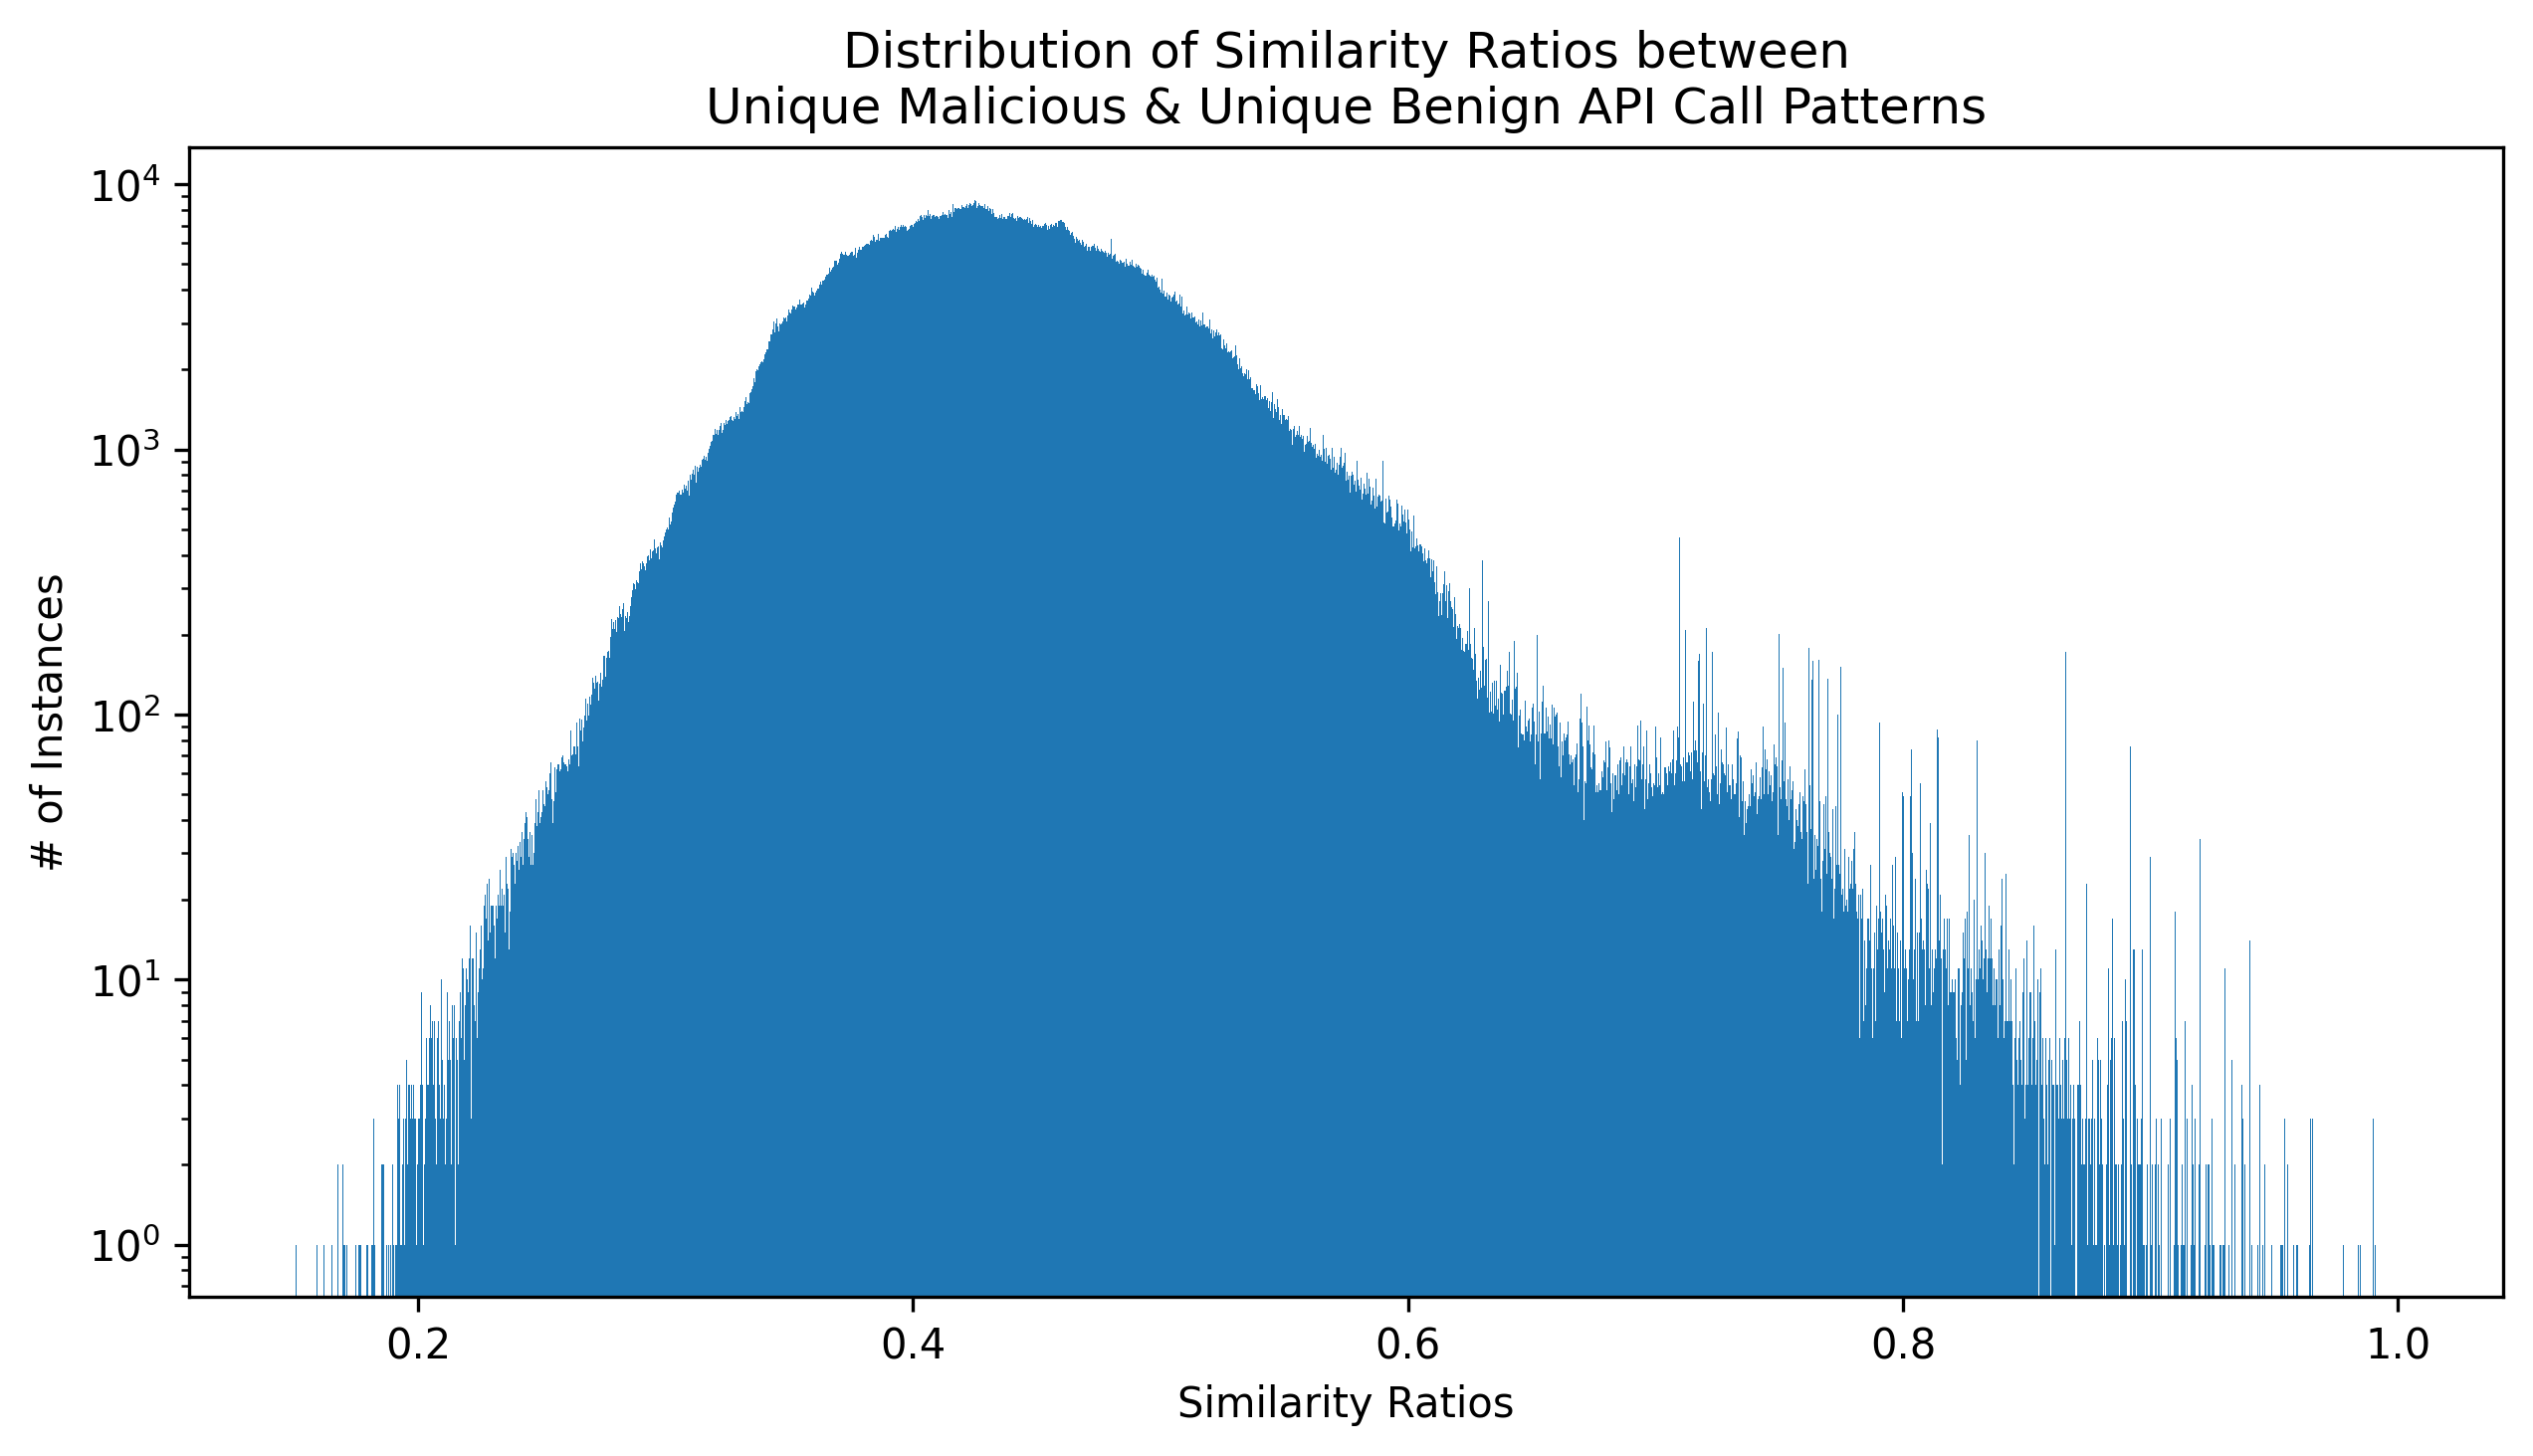

In [9]:
ratio_only = []
for r in ratios:
    ratio_only.append(r['ratio'])
plt.figure(figsize=(10,5), dpi=300)
plt.title('Distribution of Similarity Ratios between\nUnique Malicious & Unique Benign API Call Patterns')
plt.xlabel('Similarity Ratios')
plt.ylabel('# of Instances')
n, bins, patches = plt.hist(ratio_only, bins=5000, orientation='vertical', log=True)
plt.savefig("./Output/3 Distribution_Similarity_Ratio_Log.png")
plt.show()

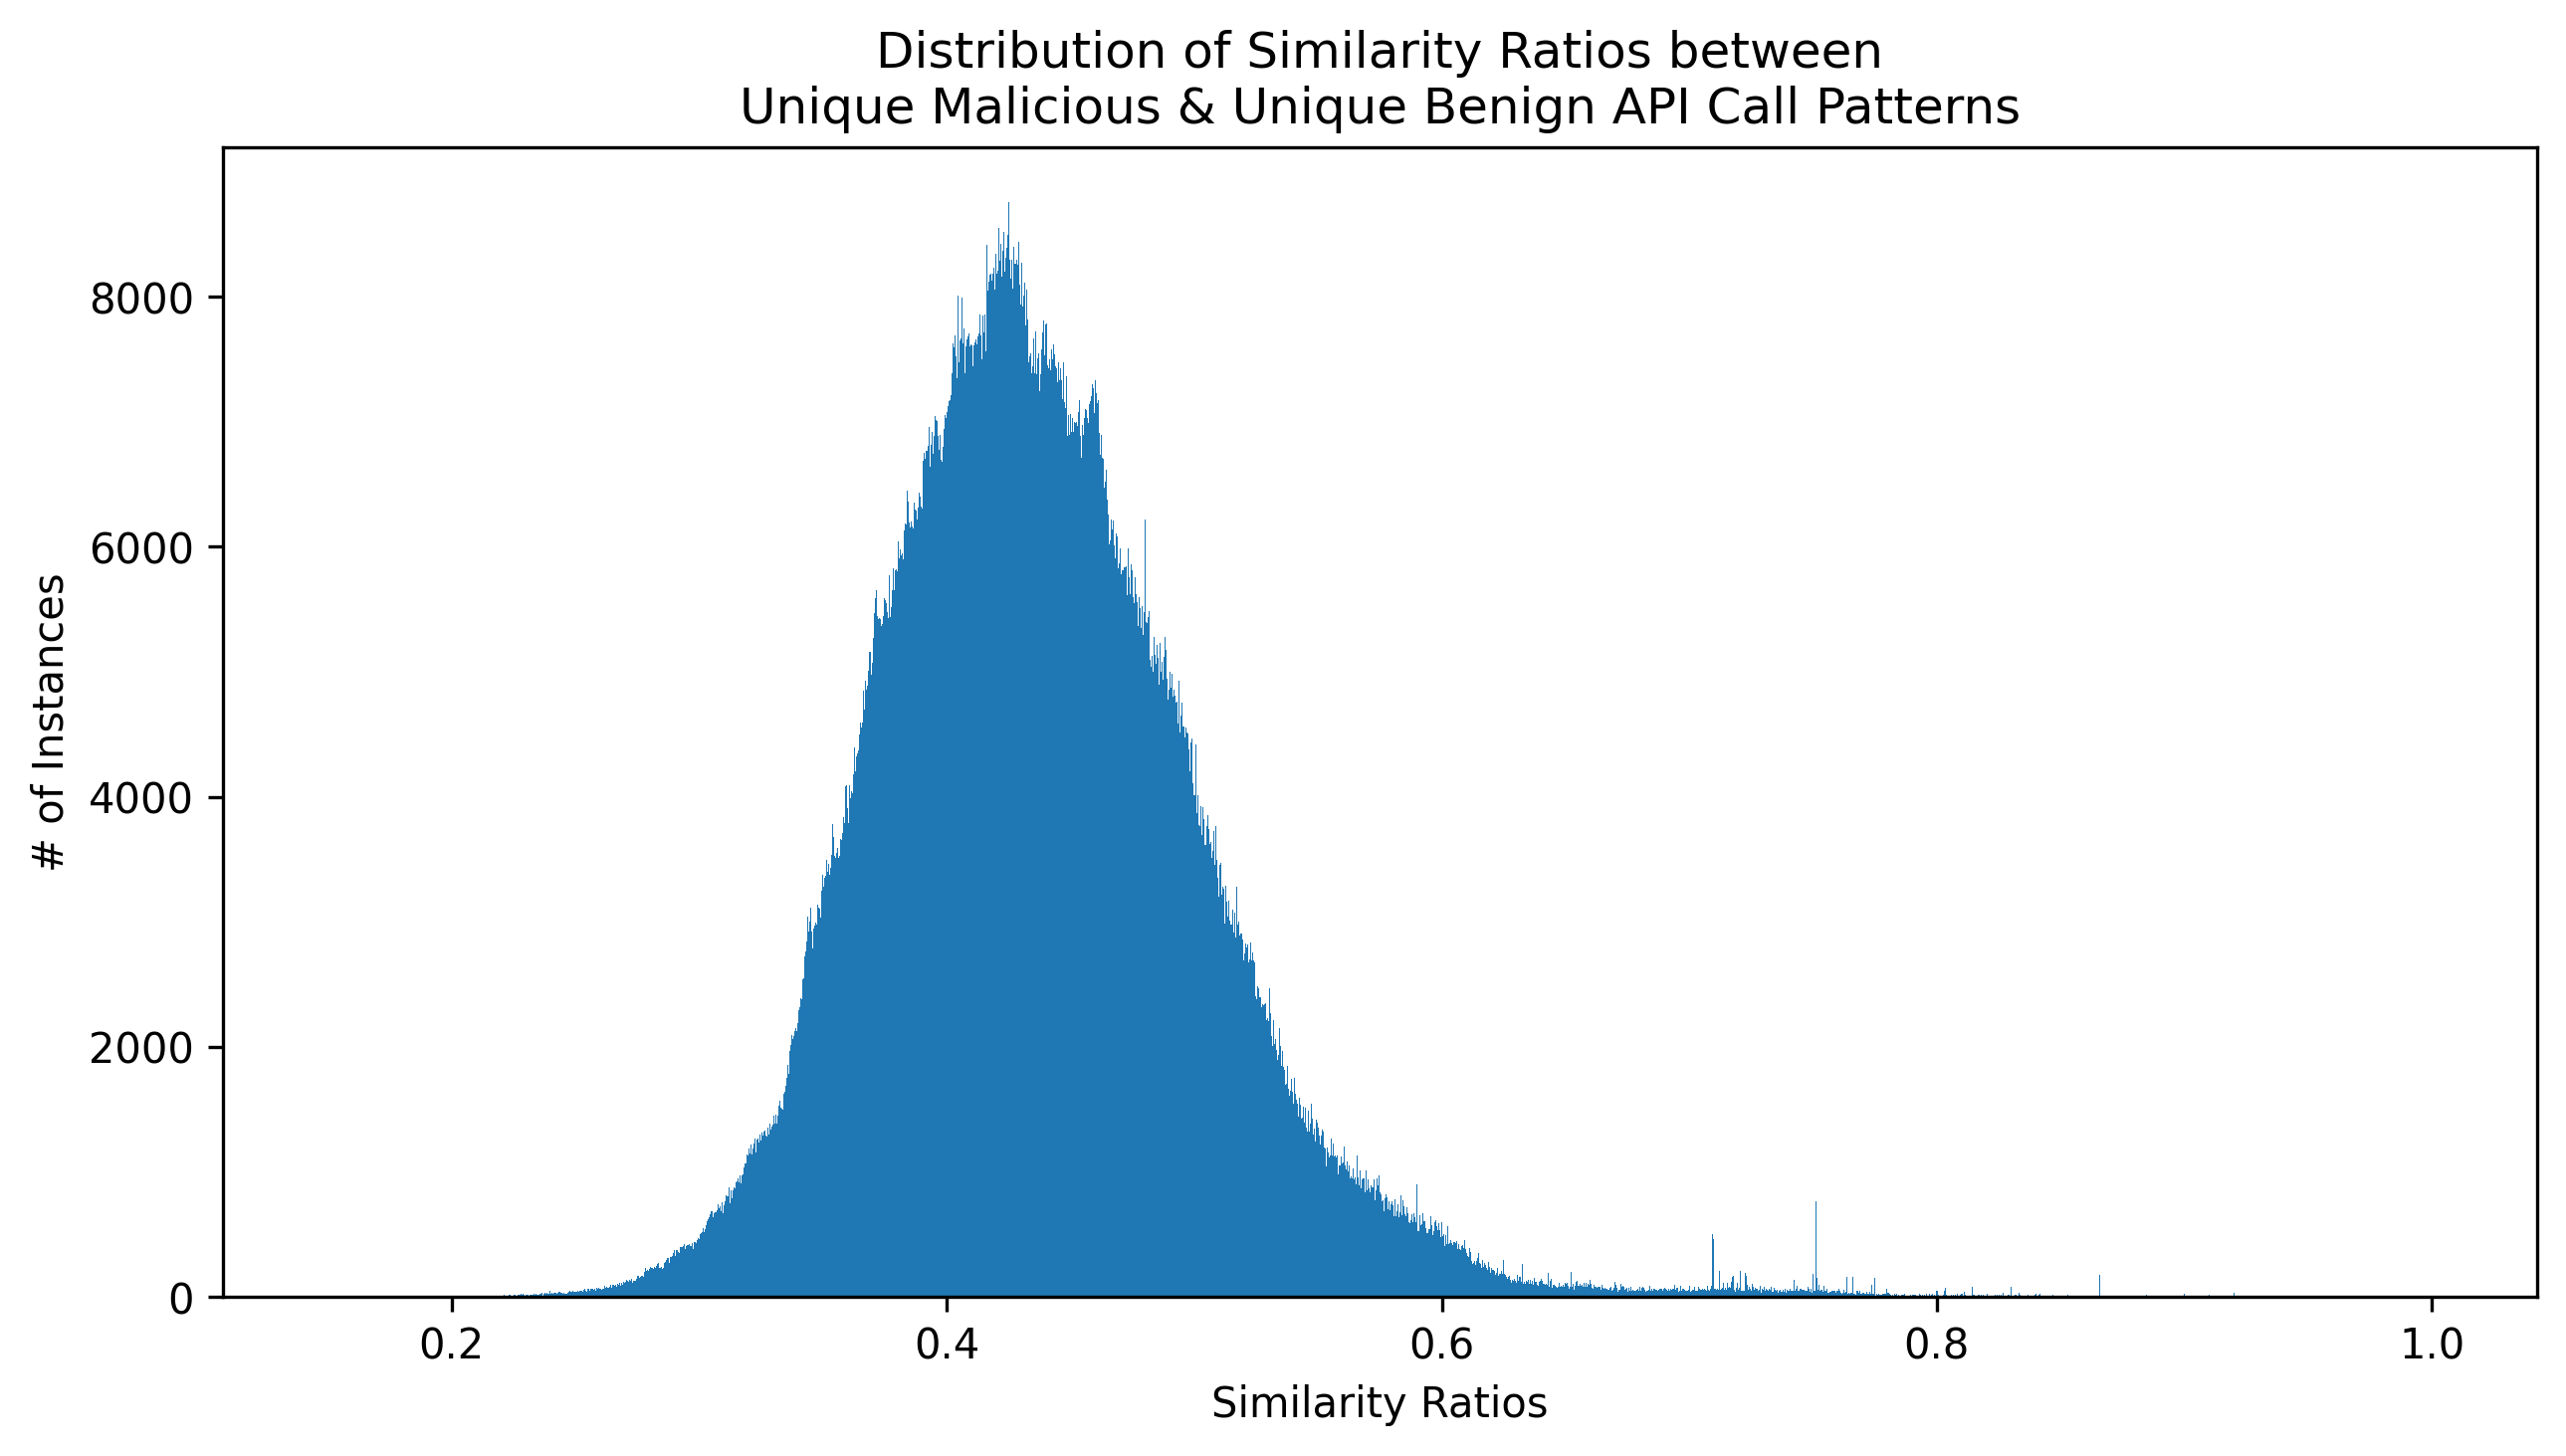

In [10]:
ratio_only = []
for r in ratios:
    ratio_only.append(r['ratio'])
plt.figure(figsize=(10,5), dpi=300)
plt.title('Distribution of Similarity Ratios between\nUnique Malicious & Unique Benign API Call Patterns')
plt.xlabel('Similarity Ratios')
plt.ylabel('# of Instances')
n, bins, patches = plt.hist(ratio_only, bins=5000, orientation='vertical', log=False)
plt.savefig("./Output/3 Distribution_Similarity_Ratio.png")
plt.show()

In [17]:
def print_comparison(types:str, ratios:list, max:int, rank='Most'):
    if max > len(ratios):
        print(f"The specified `max` value ({max}) exceeds the number available ratios to select.")
        max = len(ratios)
    states = []
    output = "====================================================================================\n\n"
    for r in range(0,max):
        output += f"MATCH {r+1}\n"
        output += f"Malicious Counts: {len(ratios[r]['malicious_hash'])}\n"
        # for t in range(len(ratios[r]['malicious_hash'])): # All malicious hashes that have the same API Call
        #     output += f"\t{ratios[r]['malicious_hash'][t]} - {ratios[r]['type'][t]}" + "\n"
        #output += f"Benign Counts: {len(ratios[r]['benign_hash'])}\n"
        # for b in range(len(ratios[r]['benign_hash'])): # All benign hashes that have the same API Call Pattern
        #     output += f"\t{ratios[r]['benign_hash'][b]}\n"
        counts = pd.Series(ratios[r]['type'])
        output += "\nMalware Type Counts:\n"
        output += counts.value_counts().to_string() + "\n"        
        output += f"Score: {ratios[r]['ratio']:.4f}\n" # Similarity Ratio
        output += f"\nMalicious API Call Pattern: {ratios[r]['malicious_pattern']}\n" # API Call Pattern (from Malicious)
        output += f"Benign API Call Pattern: {ratios[r]['benign_pattern']}\n" # API Call Pattern (from Benign)
        output += "\n"
        for t in range(len(ratios[r]['malicious_hash'])): # Malware Types of matching Malicious Samples
            states.append(ratios[r]['type'][t]) 
        output += f"\nBenign Samples ({len(ratios[r]['benign_hash'])}):\n"
        for t in range(len(ratios[r]['benign_hash'])): # Malware Types of matching Malicious Samples
            output += f"{ratios[r]['benign_hash'][t]}\n" 
        output += "====================================================================================\n\n"
    common_states = pd.Series(states).sort_values()
    output += "\n"
    output += f"Malware Types of the Top {max} {rank} Matching API Call Patterns to Benign Samples:\n"
    output += str(pd.Series(common_states).sort_values().value_counts()) + "\n"
    print(output, file=open(f"./Output/3 {types}.txt",'w'))
    print(output)

## High Matching Ratios

Samples with high matching ratio in terms of pattern (i.e., states) are ideally the following:
1. The malicious sample is a `trojan` hence must have similar behaviors as a benign software. It might be the limitation of the dataset having only the first 100 API calls and may not have included the rest.
2. The malicious sample is falsely labelled (i.e., `_ _ _`)as malicious (i.e., false-positive) which is supported by it matching the behavior of benign samples.

In [18]:
# MOST SIMILAR API CALL PATTERNS TO BOTH MALICIOUS AND BENIGN SAMPLES
top = 20 # Modify to Top n Most Similar/Different
ratios.sort(reverse=True,key=lambda ratio: ratio['ratio'])
print_comparison("HighMatching_Similar", ratios, top) 


MATCH 1
Malicious Counts: 485

Malware Type Counts:
trojan        480
downloader      2
pua             2
adware          1
Score: 1.0000

Malicious API Call Pattern: GetSystemTimeAsFileTime,GetSystemInfo,NtCreateMutant,GetSystemTimeAsFileTime,NtOpenKey,NtOpenKeyEx,LdrLoadDll,LdrGetProcedureAddress,RegOpenKeyExW,LdrGetProcedureAddress,RegQueryInfoKeyW,LdrGetProcedureAddress,RegEnumKeyExW,RegOpenKeyExW,RegQueryInfoKeyW,LdrGetProcedureAddress,RegEnumValueW,LdrGetProcedureAddress,RegCloseKey,GetFileAttributesW,RegOpenKeyExW,LdrGetProcedureAddress,RegQueryValueExW,LdrGetProcedureAddress,RegQueryValueExW,RegCloseKey,FindFirstFileExW,RegOpenKeyExW,RegQueryInfoKeyW,RegEnumValueW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,FindFirstFileExW,RegOpenKeyExW,RegQueryInfoKeyW,RegCloseKey,RegOpenKeyExW,RegQueryInfoKeyW,RegCloseKey,FindFirstFileExW,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,LdrGetDllHandle,LdrGetProcedureAddress,RegOpenKeyExW,RegQ

## Low Matching Ratios

Samples with low matching ratio in terms of pattern (i.e., states) are ideally the following:
1. The malicious sample is a `trojan` hence must have similar behaviors as a benign software. It might be the limitation of the dataset having only the first 100 API calls and may not have included the rest.
2. The malicious sample is falsely labelled as malicious (i.e., false-positive) which is supported by it matching the behavior of benign samples.

In [19]:
# MOST DIFFERENT API CALL PATTERNS TO BOTH MALICIOUS AND BENIGN SAMPLES
ratios.sort(reverse=False,key=lambda ratio: ratio['ratio'])
print_comparison("LowMatching_Different",ratios, top, 'Least')


MATCH 1
Malicious Counts: 1

Malware Type Counts:
trojan    1
Score: 0.1501

Malicious API Call Pattern: NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrLoadDll,LdrGetProcedureAddress,GetSystemWindowsDirectoryW,NtCreateFile,NtCreateSection,NtMapViewOfSection,NtClose,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProc